<a href="https://colab.research.google.com/github/PondKann/CXR-Project/blob/main/DenseNet_Pretrained_2class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### import

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import numpy as np
import pandas as pd
from torchsummary import summary
from skimage.io import imread, imsave
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import PIL
from PIL import Image


In [2]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from imutils import paths
import argparse

from sklearn.model_selection import KFold
from sklearn import metrics
from scipy.stats import zscore


import matplotlib.image as mpimg
from matplotlib.pyplot import savefig

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#### Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class/Image'

train 3 class

In [5]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### train 3 class  --- สร้างตารางเก็บ ชื่อภาพ และชื่อคลาส
ข้อมูลใน All_3class_dir รวมภาพทั้ง 3 คลาส รวม 451 ภาพ TB150, Normal151 และ CA150 (CA คือ lungcancer)

In [6]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

In [7]:
normal = []
for i in range(len(os.listdir(Normal151_dir))):
    img = os.listdir(Normal151_dir)[i]
    normal.append(img)
    
tnormal = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal"  })

In [8]:
tuberculosis = []
for i in range(len(os.listdir(TB150_dir))):
    img = os.listdir(TB150_dir)[i]
    tuberculosis.append(img)

ttuberculosis = pd.DataFrame({'ImageName':[tuberculosis][0],
                                       'NameType': "Abnormal"  })

In [9]:
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Abnormal"  })

In [10]:
data_train3 = pd.concat([tnormal, ttuberculosis, tlungcancer])
data_train3[-3:]

,ImageName,NameType
147,ca2.jpg,Abnormal
148,ca26.jpg,Abnormal
149,ca8.jpg,Abnormal


# All Abnormal

## 1) K-fold  -- DenseNet201

### -->ACC = 0.92
### -->เวลา 4027 วินาที

*   BS = 8
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 301/301 [00:04<00:00, 70.49it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 8
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))



Fold #1
Epoch 1/30
45/45 [==============================] - 93s 2s/step - loss: 0.6545 - accuracy: 0.6222 - val_loss: 0.6129 - val_accuracy: 0.6484
Epoch 2/30
45/45 [==============================] - 91s 2s/step - loss: 0.5956 - accuracy: 0.6778 - val_loss: 0.5920 - val_accuracy: 0.6484
Epoch 3/30
45/45 [==============================] - 88s 2s/step - loss: 0.5631 - accuracy: 0.6806 - val_loss: 0.5738 - val_accuracy: 0.7473
Epoch 4/30
45/45 [==============================] - 86s 2s/step - loss: 0.5578 - accuracy: 0.6972 - val_loss: 0.5546 - val_accuracy: 0.7582
Epoch 5/30
45/45 [==============================] - 80s 2s/step - loss: 0.5346 - accuracy: 0.7083 - val_loss: 0.5376 - val_accuracy: 0.7802
Epoch 6/30
45/45 [==============================] - 85s 2s/step - loss: 0.5004 - accuracy: 0.7194 - val_loss: 0.5236 - val_accuracy: 0.8022
Epoch 7/30
45/45 [==============================] - 86s 2s/step - loss: 0.4917 - accuracy: 0.7556 - val_loss: 0.5076 - val_accuracy: 0.8352
Epoch 8/30
4

In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
score = metrics.accuracy_score(oos_y.argmax(axis=1),	        #ค่า acc
                                             oos_pred.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.9157427937915743
              precision    recall  f1-score   support

    Abnormal       0.96      0.91      0.93       300
      Normal       0.84      0.93      0.88       151

    accuracy                           0.92       451
   macro avg       0.90      0.92      0.91       451
weighted avg       0.92      0.92      0.92       451



### training  
- binary_crossentropy
- categorical_crossentropy
- RMSprop 
- Adam
- ModelCheckpoint():
ใช้ในการทำ Save Model ที่ดีที่สุดในทุกรอบของการ Modeling
นามสกุลก็จะเป็น .5df เฉพาะ Packages Keras เท่านั้น
- ReduceLROnPlateau(): ใช้ในการลด Learning Rate (ความเร็วในการค้นหาจุดไหนคือ Global Minima)
    - monitor= ’val_loss’: ใช้ Criteria อะไรในการลด Learning Rate
    - patience= 5: ทนรอได้กี่ epoch ก่อนที่จะทำการลดค่า learning rate
    - verbose= 2: รูปแบบการแสดงผลหากเกิด Effect
    - factor= 0.5: หากไม่สามารถลด loss ได้ใน 5 epoch ทำการลด learning rate 50%

#### 8 soft pre bi  
-->   0.92

In [ ]:
BS = 8
filepath = "model8_soft_pre_bi.h5"

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:07<00:00, 60.22it/s] 


In [ ]:
(x_train_Dense1, x_test_Dense1, y_train_Dense1, y_test_Dense1 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H8_soft_pre_bi = model_Dense.fit( x=aug.flow(x_train_Dense1, y_train_Dense1, batch_size=BS ),
	                                            validation_data=(x_test_Dense1, y_test_Dense1),
	                                            steps_per_epoch=len(x_train_Dense1) // BS,
	                                            epochs=100 ,  callbacks = [callback, checkpoint, reduce_lr])
    
pred_8_soft_pre_bi = model_Dense.predict(x_test_Dense1)
    
print(classification_report(y_test_Dense1.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_8_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.6527 - accuracy: 0.6333
Epoch 1: val_accuracy improved from -inf to 0.62832, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 131s 3s/step - loss: 0.6527 - accuracy: 0.6333 - val_loss: 0.6365 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.6091 - accuracy: 0.6667
Epoch 2: val_accuracy improved from 0.62832 to 0.63717, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 96s 2s/step - loss: 0.6091 - accuracy: 0.6667 - val_loss: 0.6118 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.5754 - accuracy: 0.6788
Epoch 3: val_accuracy did not improve from 0.63717
42/42 [==============================] - 101s 2s/step - loss: 0.5754 - accuracy: 0.6788 - val_loss: 0.5918 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 4/100
42/42 [====================

In [ ]:
model_Dense.summary()

In [ ]:
model_Dense.save("path_to_my_model")

In [ ]:
tt = tf.keras.models.load_model('/content/model8_soft_pre_bi.h5')

In [ ]:
tt

In [ ]:
weights = tt.get_weights()
len(weights)

1006

In [ ]:
#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( "model8_soft_pre_bi.h5" )  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

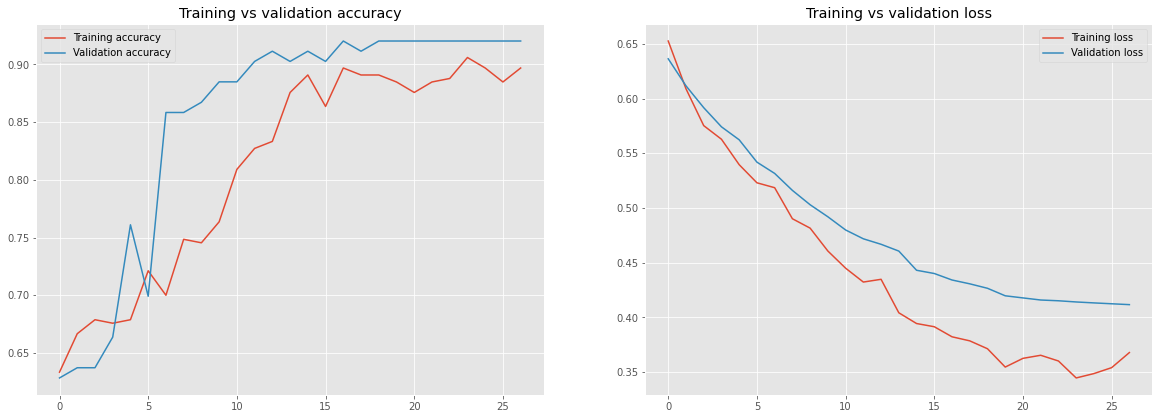

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense1 = H8_soft_pre_bi               ##
pred_Dense1 = pred_8_soft_pre_bi    ##


accuracy = H_Dense1.history['accuracy']
val_accuracy  = H_Dense1.history['val_accuracy']

loss = H_Dense1.history['loss']
val_loss = H_Dense1.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

# plt.savefig("CNN_Model")  เซฟรูปไม่ได้

##### Confusion matrix

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

cf.go_offline()

Confusion matrix, without normalization
[[66  6]
 [ 3 38]]


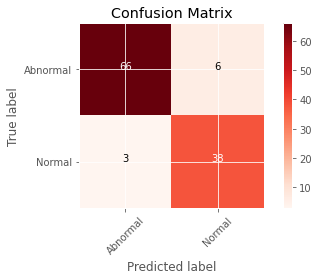

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(y_test_Dense1.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_Dense1.argmax(axis=1))
cm_plot_labels = le_Dense.classes_

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

สี cmap https://matplotlib.org/stable/tutorials/colors/colormaps.html

Confusion matrix, without normalization
[[66  6]
 [ 3 38]]
Normalized confusion matrix
[[0.92 0.08]
 [0.07 0.93]]


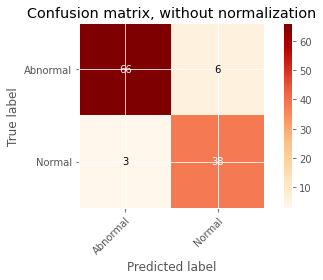

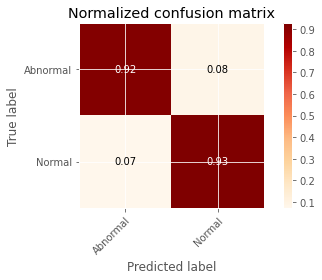

In [ ]:
y_pred = pred_Dense1.argmax(axis=1)
y_true  = y_test_Dense1.argmax(axis=1)
y_test = y_test_Dense1.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre bi adam
-->   0.90

In [ ]:
BS = 8
filepath = "model8_soft_pre_bi_adam.h5"

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:07<00:00, 62.95it/s]


In [ ]:
(x_train_Dense1, x_test_Dense1, y_train_Dense1, y_test_Dense1 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense1 = model_Dense.fit( x=aug.flow(x_train_Dense1, y_train_Dense1, batch_size=BS ),
	                                            validation_data=(x_test_Dense1, y_test_Dense1),
	                                            steps_per_epoch=len(x_train_Dense1) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr]) 
    
pred_Dense1 = model_Dense.predict(x_test_Dense1)
    
print(classification_report(y_test_Dense1.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense1.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.6121
Epoch 1: val_accuracy improved from -inf to 0.65487, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 127s 3s/step - loss: 0.6478 - accuracy: 0.6121 - val_loss: 0.6243 - val_accuracy: 0.6549 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.6758
Epoch 2: val_accuracy improved from 0.65487 to 0.66372, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 99s 2s/step - loss: 0.5888 - accuracy: 0.6758 - val_loss: 0.6035 - val_accuracy: 0.6637 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.6845
Epoch 3: val_accuracy improved from 0.66372 to 0.68142, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 100s 2s/step - loss: 0.5646 - accuracy: 0.6845 - val_loss: 0.5864 - val_accuracy: 0.681

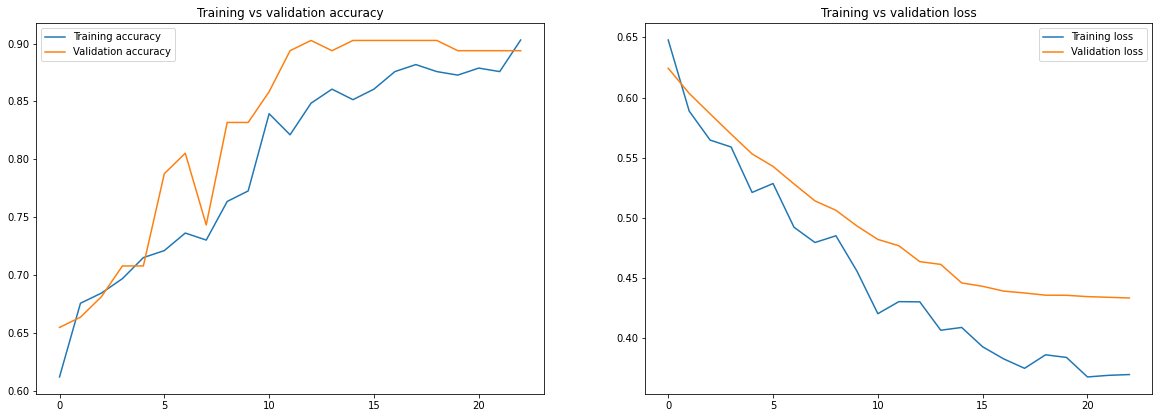

<Figure size 432x288 with 0 Axes>

In [ ]:
accuracy = H_Dense1.history['accuracy']
val_accuracy  = H_Dense1.history['val_accuracy']

loss = H_Dense1.history['loss']
val_loss = H_Dense1.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

# plt.savefig("CNN_Model")  เซฟรูปไม่ได้

##### Confusion matrix

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

Confusion matrix, without normalization
[[65  7]
 [ 5 36]]


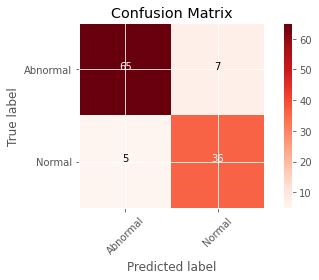

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(y_test_Dense1.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_Dense1.argmax(axis=1))
cm_plot_labels = le_Dense.classes_

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

สี cmap https://matplotlib.org/stable/tutorials/colors/colormaps.html

Confusion matrix, without normalization
[[65  7]
 [ 5 36]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.12 0.88]]


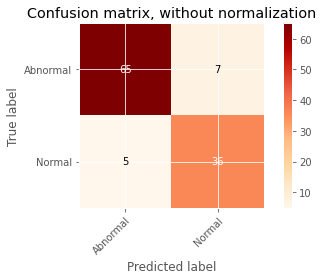

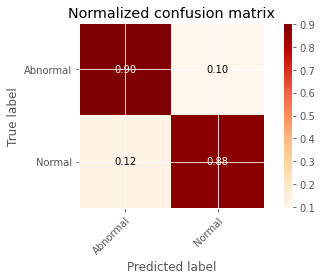

In [ ]:
y_pred = pred_Dense1.argmax(axis=1)
y_true  = y_test_Dense1.argmax(axis=1)
y_test = y_test_Dense1.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre cate
-->   0.88

In [ ]:
BS = 8
filepath = "model8_soft_pre_cate.h5"

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")
callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:07<00:00, 59.84it/s] 


In [ ]:
(x_train_Dense1, x_test_Dense1, y_train_Dense1, y_test_Dense1 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

H_Dense1 = model_Dense.fit( x=aug.flow(x_train_Dense1, y_train_Dense1, batch_size=BS ),
	                                            validation_data=(x_test_Dense1, y_test_Dense1),
	                                            steps_per_epoch=len(x_train_Dense1) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint, reduce_lr]) 
    
pred_Dense1 = model_Dense.predict(x_test_Dense1)
    
print(classification_report(y_test_Dense1.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense1.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.7061
Epoch 1: val_accuracy improved from -inf to 0.69912, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 120s 2s/step - loss: 0.5727 - accuracy: 0.7061 - val_loss: 0.5643 - val_accuracy: 0.6991 - lr: 1.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.7091
Epoch 2: val_accuracy improved from 0.69912 to 0.71681, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 100s 2s/step - loss: 0.5393 - accuracy: 0.7091 - val_loss: 0.5333 - val_accuracy: 0.7168 - lr: 1.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.5358 - accuracy: 0.7424
Epoch 3: val_accuracy improved from 0.71681 to 0.75221, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 97s 2s/step - loss: 0.5358 - accuracy: 0.7424 - val_loss: 0.5086 - val_accuracy: 0.7522 - lr: 1.00

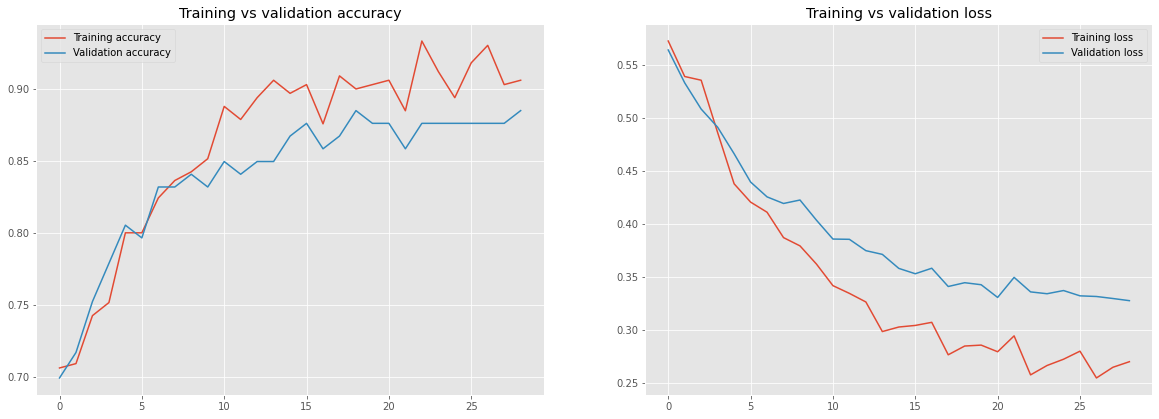

<Figure size 432x288 with 0 Axes>

In [ ]:
accuracy = H_Dense1.history['accuracy']                                   #
val_accuracy  = H_Dense1.history['val_accuracy']                      #

loss = H_Dense1.history['loss']                                                 #
val_loss = H_Dense1.history['val_loss']                                     #
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

# plt.savefig("CNN_Model")  เซฟรูปไม่ได้

##### Confusion matrix

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

Confusion matrix, without normalization
[[61 11]
 [ 2 39]]


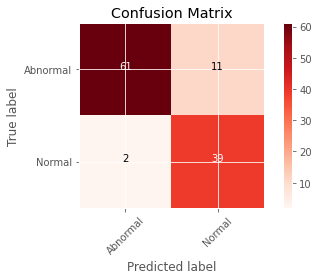

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(y_test_Dense1.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                    pred_Dense1.argmax(axis=1))
cm_plot_labels = le_Dense.classes_

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

สี cmap https://matplotlib.org/stable/tutorials/colors/colormaps.html

Confusion matrix, without normalization
[[61 11]
 [ 2 39]]
Normalized confusion matrix
[[0.85 0.15]
 [0.05 0.95]]


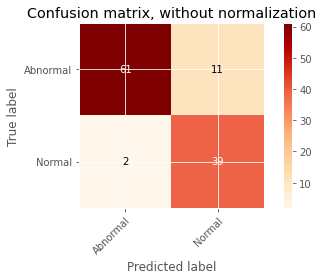

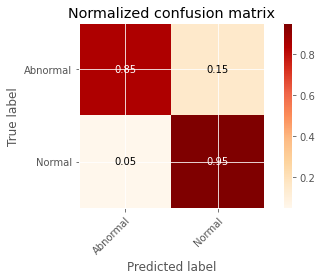

In [ ]:
y_pred = pred_Dense1.argmax(axis=1)
y_true  = y_test_Dense1.argmax(axis=1)
y_test = y_test_Dense1.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre cate adam
-->   0.87

In [ ]:
BS = 8
filepath = "model8_soft_pre_cate_adam.h5"

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")
callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:08<00:00, 55.98it/s]


In [ ]:
(x_train_Dense1, x_test_Dense1, y_train_Dense1, y_test_Dense1 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

H8soft_pre_cate_adam = model_Dense.fit( x=aug.flow(x_train_Dense1, y_train_Dense1, batch_size=BS ),
	                                            validation_data=(x_test_Dense1, y_test_Dense1),
	                                            steps_per_epoch=len(x_train_Dense1) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr]) 
    
pred_Dense1 = model_Dense.predict(x_test_Dense1)
    
print(classification_report(y_test_Dense1.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense1.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.6476 - accuracy: 0.6394
Epoch 1: val_accuracy improved from -inf to 0.57522, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 112s 2s/step - loss: 0.6476 - accuracy: 0.6394 - val_loss: 0.6551 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.6788
Epoch 2: val_accuracy improved from 0.57522 to 0.63717, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 98s 2s/step - loss: 0.5868 - accuracy: 0.6788 - val_loss: 0.6253 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.5400 - accuracy: 0.7333
Epoch 3: val_accuracy improved from 0.63717 to 0.65487, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 97s 2s/step - loss: 0.5400 - accuracy: 0.7333 - val_loss: 0.5757 - val_accuracy: 

## 1.2) K-fold  -- DenseNet201

### -->ACC = 0.86
### -->เวลา 52 นาที

*   BS = 8
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 301/301 [00:04<00:00, 72.77it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS8 = 8
EPOCHS = 50

aug12 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
45/45 [==============================] - 93s 2s/step - loss: 0.6249 - accuracy: 0.6750 - val_loss: 0.6455 - val_accuracy: 0.6374
Epoch 2/30
45/45 [==============================] - 83s 2s/step - loss: 0.6068 - accuracy: 0.6750 - val_loss: 0.6221 - val_accuracy: 0.6374
Epoch 3/30
45/45 [==============================] - 86s 2s/step - loss: 0.5727 - accuracy: 0.6861 - val_loss: 0.6015 - val_accuracy: 0.6374
Epoch 4/30
45/45 [==============================] - 84s 2s/step - loss: 0.5549 - accuracy: 0.6778 - val_loss: 0.5794 - val_accuracy: 0.6374


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Abnormal       0.64      1.00      0.78        58
      Normal       0.00      0.00      0.00        33

    accuracy                           0.64        91
   macro avg       0.32      0.50      0.39        91
weighted avg       0.41      0.64      0.50        91

Fold #2
Epoch 1/30
45/45 [==============================] - 81s 2s/step - loss: 0.5478 - accuracy: 0.6714 - val_loss: 0.5125 - val_accuracy: 0.8333
Epoch 2/30
45/45 [==============================] - 82s 2s/step - loss: 0.5187 - accuracy: 0.7082 - val_loss: 0.4962 - val_accuracy: 0.8556
Epoch 3/30
45/45 [==============================] - 103s 2s/step - loss: 0.5005 - accuracy: 0.7337 - val_loss: 0.4844 - val_accuracy: 0.8889
Epoch 4/30
45/45 [==============================] - 107s 2s/step - loss: 0.4910 - accuracy: 0.7762 - val_loss: 0.4653 - val_accuracy: 0.9111
Epoch 5/30
45/45 [==============================] - 89s 2s/step - loss: 0.4694 - accuracy: 0.8045 - val

In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
score = metrics.accuracy_score(oos_y.argmax(axis=1),	        #ค่า acc
                                             oos_pred.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8580931263858093
              precision    recall  f1-score   support

    Abnormal       0.86      0.95      0.90       300
      Normal       0.87      0.68      0.76       151

    accuracy                           0.86       451
   macro avg       0.86      0.81      0.83       451
weighted avg       0.86      0.86      0.85       451



### training  
- binary_crossentropy
- categorical_crossentropy
- RMSprop 
- Adam

#### 8 soft pre bi 
--> 0.83

In [ ]:
BS = 8

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
(x_train_Dense12, x_test_Dense12, y_train_Dense12, y_test_Dense12 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense12 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense12.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense12 = model_Dense12.fit( x=aug12.flow(x_train_Dense12, y_train_Dense12, batch_size=BS8),
	                                            validation_data=(x_test_Dense12, y_test_Dense12),
	                                            steps_per_epoch=len(x_train_Dense12) // BS8,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense12 = model_Dense12.predict(x_test_Dense12)
    
print(classification_report(y_test_Dense12.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense12.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
28/28 [==============================] - 90s 3s/step - loss: 0.7510 - accuracy: 0.4700 - val_loss: 0.6981 - val_accuracy: 0.5263
Epoch 2/30
28/28 [==============================] - 76s 3s/step - loss: 0.6884 - accuracy: 0.5392 - val_loss: 0.6711 - val_accuracy: 0.6447
Epoch 3/30
28/28 [==============================] - 77s 3s/step - loss: 0.6598 - accuracy: 0.6452 - val_loss: 0.6520 - val_accuracy: 0.6842
Epoch 4/30
28/28 [==============================] - 76s 3s/step - loss: 0.6417 - accuracy: 0.7281 - val_loss: 0.6351 - val_accuracy: 0.7632
Epoch 5/30
28/28 [==============================] - 76s 3s/step - loss: 0.6301 - accuracy: 0.7235 - val_loss: 0.6205 - val_accuracy: 0.8026
Epoch 6/30
28/28 [==============================] - 76s 3s/step - loss: 0.6107 - accuracy: 0.7512 - val_loss: 0.6061 - val_accuracy: 0.8289
Epoch 7/30
28/28 [==============================] - 77s 3s/step - loss: 0.5991 - accuracy: 0.7650 - val_loss: 0.5930 - val_accuracy: 0.7763
Epoch 8/30
28/28 [==

#### 8 sig pre bi adam
--> 0.

In [ ]:
BS = 8

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
(x_train_Dense12, x_test_Dense12, y_train_Dense12, y_test_Dense12 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense12 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense12.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense12 = model_Dense12.fit( x=aug12.flow(x_train_Dense12, y_train_Dense12, batch_size=BS8),
	                                            validation_data=(x_test_Dense12, y_test_Dense12),
	                                            steps_per_epoch=len(x_train_Dense12) // BS8,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense12 = model_Dense12.predict(x_test_Dense12)
    
print(classification_report(y_test_Dense12.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense12.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 8 soft pre cate 
--> 0.

In [ ]:
BS = 8

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
(x_train_Dense12, x_test_Dense12, y_train_Dense12, y_test_Dense12 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense12 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense12.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

H_Dense12 = model_Dense12.fit( x=aug12.flow(x_train_Dense12, y_train_Dense12, batch_size=BS8),
	                                            validation_data=(x_test_Dense12, y_test_Dense12),
	                                            steps_per_epoch=len(x_train_Dense12) // BS8,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense12 = model_Dense12.predict(x_test_Dense12)
    
print(classification_report(y_test_Dense12.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense12.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
28/28 [==============================] - 90s 3s/step - loss: 0.7510 - accuracy: 0.4700 - val_loss: 0.6981 - val_accuracy: 0.5263
Epoch 2/30
28/28 [==============================] - 76s 3s/step - loss: 0.6884 - accuracy: 0.5392 - val_loss: 0.6711 - val_accuracy: 0.6447
Epoch 3/30
28/28 [==============================] - 77s 3s/step - loss: 0.6598 - accuracy: 0.6452 - val_loss: 0.6520 - val_accuracy: 0.6842
Epoch 4/30
28/28 [==============================] - 76s 3s/step - loss: 0.6417 - accuracy: 0.7281 - val_loss: 0.6351 - val_accuracy: 0.7632
Epoch 5/30
28/28 [==============================] - 76s 3s/step - loss: 0.6301 - accuracy: 0.7235 - val_loss: 0.6205 - val_accuracy: 0.8026
Epoch 6/30
28/28 [==============================] - 76s 3s/step - loss: 0.6107 - accuracy: 0.7512 - val_loss: 0.6061 - val_accuracy: 0.8289
Epoch 7/30
28/28 [==============================] - 77s 3s/step - loss: 0.5991 - accuracy: 0.7650 - val_loss: 0.5930 - val_accuracy: 0.7763
Epoch 8/30
28/28 [==

#### 8 sig pre cate adam
--> 0.

In [ ]:
BS = 8

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
(x_train_Dense12, x_test_Dense12, y_train_Dense12, y_test_Dense12 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense12 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense12.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

H_Dense12 = model_Dense12.fit( x=aug12.flow(x_train_Dense12, y_train_Dense12, batch_size=BS8),
	                                            validation_data=(x_test_Dense12, y_test_Dense12),
	                                            steps_per_epoch=len(x_train_Dense12) // BS8,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense12 = model_Dense12.predict(x_test_Dense12)
    
print(classification_report(y_test_Dense12.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense12.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

## 2) K-fold  -- DenseNet201

### -->ACC = 0.85
### -->เวลา 4053 วินาที

*   BS = 16
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 301/301 [00:04<00:00, 63.96it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug2 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   # unit 2
model_Dense2 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense2 = KFold(5, shuffle=True, random_state=40) 

oos_y2 = []
oos_pred2 = []
fold = 0

for train, test in kf_Dense2.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense2 = data_Dense[train]
    y_train_Dense2 = labels_Dense[train]
    x_test_Dense2 = data_Dense[test]
    y_test_Dense2 = labels_Dense[test]

    H_Dense2 = model_Dense2.fit( x=aug2.flow(x_train_Dense2, y_train_Dense2, batch_size=BS16),
	                                            validation_data=(x_test_Dense2, y_test_Dense2),
	                                            steps_per_epoch=len(x_train_Dense2) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
    oos_y2.append(y_test_Dense2)
    oos_pred2.append(pred_Dense2)  
    print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))


Fold #1
Epoch 1/30
22/22 [==============================] - 88s 4s/step - loss: 0.6728 - accuracy: 0.6541 - val_loss: 0.6620 - val_accuracy: 0.6374
Epoch 2/30
22/22 [==============================] - 79s 4s/step - loss: 0.6526 - accuracy: 0.6628 - val_loss: 0.6418 - val_accuracy: 0.6374
Epoch 3/30
22/22 [==============================] - 83s 4s/step - loss: 0.6278 - accuracy: 0.6676 - val_loss: 0.6274 - val_accuracy: 0.6374
Epoch 4/30
22/22 [==============================] - 89s 4s/step - loss: 0.6098 - accuracy: 0.6686 - val_loss: 0.6091 - val_accuracy: 0.6374


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Abnormal       0.64      1.00      0.78        58
      Normal       0.00      0.00      0.00        33

    accuracy                           0.64        91
   macro avg       0.32      0.50      0.39        91
weighted avg       0.41      0.64      0.50        91

Fold #2
Epoch 1/30
22/22 [==============================] - 94s 4s/step - loss: 0.6070 - accuracy: 0.6522 - val_loss: 0.5750 - val_accuracy: 0.6889
Epoch 2/30
22/22 [==============================] - 81s 4s/step - loss: 0.5786 - accuracy: 0.6638 - val_loss: 0.5656 - val_accuracy: 0.7111
Epoch 3/30
22/22 [==============================] - 84s 4s/step - loss: 0.5658 - accuracy: 0.6725 - val_loss: 0.5493 - val_accuracy: 0.7222
Epoch 4/30
22/22 [==============================] - 84s 4s/step - loss: 0.5496 - accuracy: 0.6870 - val_loss: 0.5324 - val_accuracy: 0.7222
Epoch 5/30
22/22 [==============================] - 83s 4s/step - loss: 0.5305 - accuracy: 0.7043 - val_l

In [ ]:
oos_y2 = np.concatenate(oos_y2)
oos_pred2 = np.concatenate(oos_pred2)

In [ ]:
score = metrics.accuracy_score(oos_y2.argmax(axis=1),	        #ค่า acc
                                             oos_pred2.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8492239467849224
              precision    recall  f1-score   support

    Abnormal       0.85      0.94      0.89       300
      Normal       0.85      0.66      0.75       151

    accuracy                           0.85       451
   macro avg       0.85      0.80      0.82       451
weighted avg       0.85      0.85      0.84       451



### training  
- binary_crossentropy
- categorical_crossentropy
- RMSprop 
- Adam

#### 16  soft pre bi
--> 0.65

--> GPU 0.88

In [29]:
BS16 = 16                                                       ##
filepath = "model16_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 84.92it/s] 


In [30]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [31]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H16_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS16),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS16,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H16_soft_pre_bi = model_Dense.predict(x_test_Dense)
    
    

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.6863
Epoch 1: val_accuracy improved from -inf to 0.61947, saving model to model16_soft_pre_bi.h5
21/21 [==============================] - 28s 630ms/step - loss: 0.6168 - accuracy: 0.6863 - val_loss: 0.6356 - val_accuracy: 0.6195 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.5785 - accuracy: 0.6863
Epoch 2: val_accuracy improved from 0.61947 to 0.62832, saving model to model16_soft_pre_bi.h5
21/21 [==============================] - 8s 364ms/step - loss: 0.5785 - accuracy: 0.6863 - val_loss: 0.6215 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.6708
Epoch 3: val_accuracy improved from 0.62832 to 0.64602, saving model to model16_soft_pre_bi.h5
21/21 [==============================] - 8s 369ms/step - loss: 0.5743 - accuracy: 0.6708 - val_loss: 0.6112 - val_accuracy: 0.6460 - lr:

In [32]:
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)    

              precision    recall  f1-score   support

    Abnormal       0.89      0.90      0.90        72
      Normal       0.82      0.80      0.81        41

    accuracy                           0.87       113
   macro avg       0.86      0.85      0.86       113
weighted avg       0.87      0.87      0.87       113



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

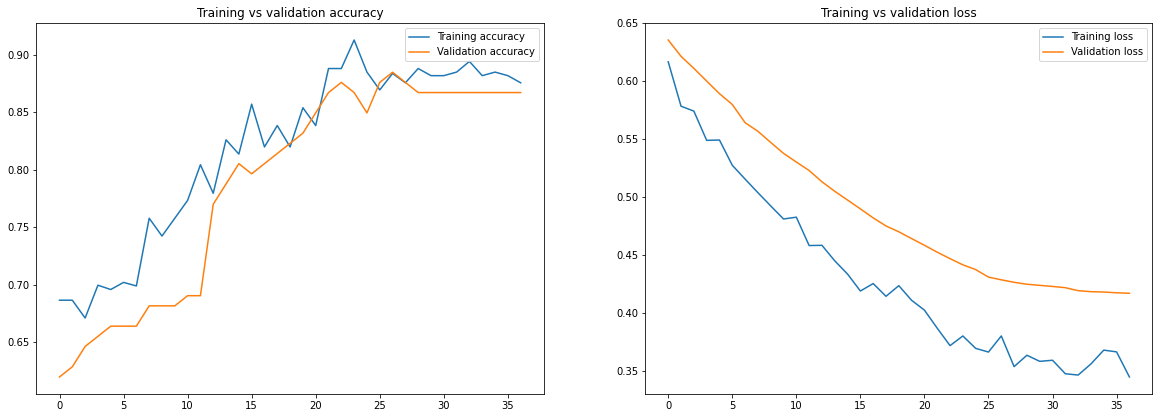

<Figure size 432x288 with 0 Axes>

In [33]:
H_Dense = H16_soft_pre_bi                            ##
pred_Dense = pred_H16_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[65  7]
 [ 8 33]]
Normalized confusion matrix
[[0.9 0.1]
 [0.2 0.8]]


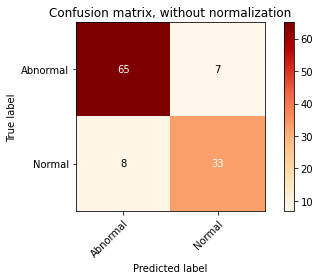

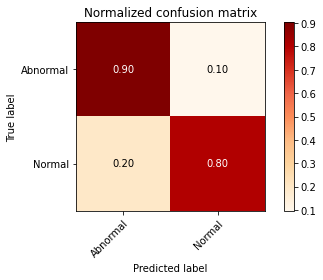

In [34]:
y_pred = pred_H16_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre bi adam
--> 0.867

In [ ]:
BS16 = 16                                                       ##
filepath = "model16_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:06<00:00, 67.70it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS16),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS16,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.6708
Epoch 1: val_accuracy improved from -inf to 0.62832, saving model to model16_soft_pre_bi_adam.h5
21/21 [==============================] - 192s 7s/step - loss: 0.6809 - accuracy: 0.6708 - val_loss: 0.6521 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.6677
Epoch 2: val_accuracy improved from 0.62832 to 0.63717, saving model to model16_soft_pre_bi_adam.h5
21/21 [==============================] - 98s 5s/step - loss: 0.6190 - accuracy: 0.6677 - val_loss: 0.6190 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.6677
Epoch 3: val_accuracy did not improve from 0.63717
21/21 [==============================] - 99s 5s/step - loss: 0.6103 - accuracy: 0.6677 - val_loss: 0.6057 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 4/100
21/21 [=========

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

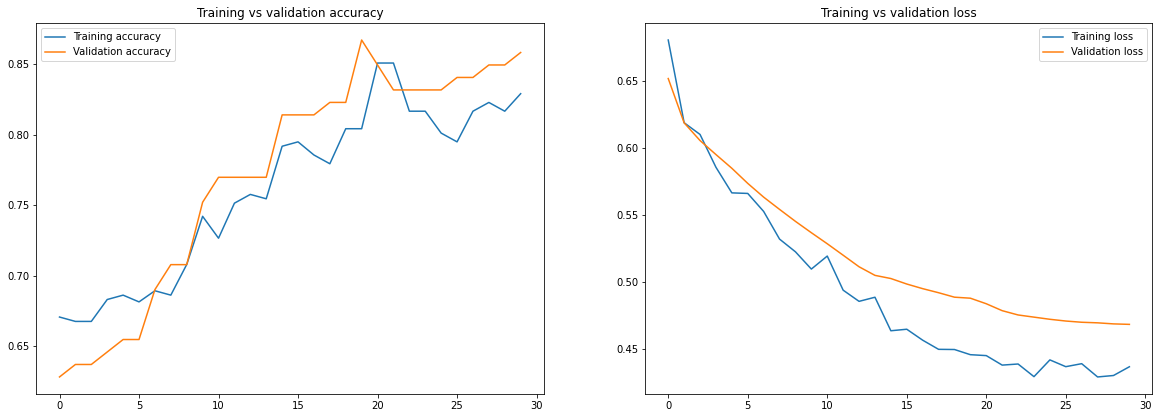

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_bi_adam                            ##
pred_Dense = pred_H16_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[69  3]
 [13 28]]
Normalized confusion matrix
[[0.96 0.04]
 [0.32 0.68]]


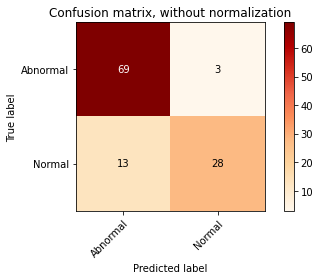

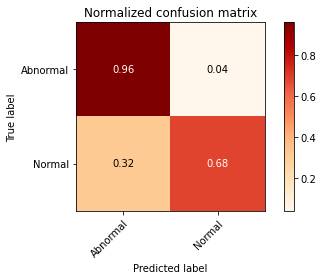

In [ ]:
y_pred = pred_H16_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre cate 
--> 0.89

In [ ]:
BS16 = 16                                                       ##
filepath = "model16_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [03:32<00:00,  2.12it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS16),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS16,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.6304
Epoch 1: val_accuracy improved from -inf to 0.62832, saving model to model16_soft_pre_cate_adam.h5
21/21 [==============================] - 97s 4s/step - loss: 0.6036 - accuracy: 0.6304 - val_loss: 0.6436 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.7019
Epoch 2: val_accuracy did not improve from 0.62832
21/21 [==============================] - 85s 4s/step - loss: 0.5782 - accuracy: 0.7019 - val_loss: 0.6276 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.7236
Epoch 3: val_accuracy improved from 0.62832 to 0.67257, saving model to model16_soft_pre_cate_adam.h5
21/21 [==============================] - 86s 4s/step - loss: 0.5486 - accuracy: 0.7236 - val_loss: 0.5834 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

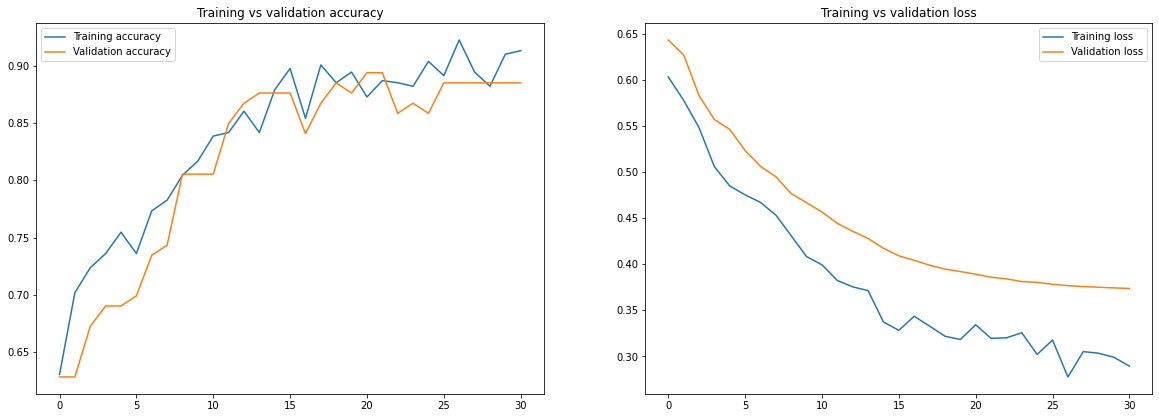

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_cate                            ##
pred_Dense = pred_H16_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[68  4]
 [ 9 32]]
Normalized confusion matrix
[[0.94 0.06]
 [0.22 0.78]]


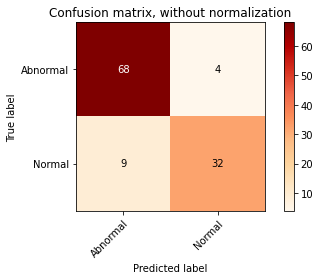

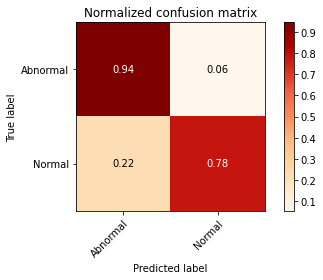

In [ ]:
y_pred = pred_H16_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre cate adam
--> 0.80

-->  GPU 0.83

In [35]:
BS16 = 16                                                       ##
filepath = "model16_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:09<00:00, 48.22it/s]


In [36]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [37]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS16),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS16,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])


Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.7143
Epoch 1: val_accuracy improved from -inf to 0.62832, saving model to model16_soft_pre_cate_adam.h5
21/21 [==============================] - 35s 776ms/step - loss: 0.5529 - accuracy: 0.7143 - val_loss: 0.6080 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.4963 - accuracy: 0.7236
Epoch 2: val_accuracy improved from 0.62832 to 0.66372, saving model to model16_soft_pre_cate_adam.h5
21/21 [==============================] - 10s 501ms/step - loss: 0.4963 - accuracy: 0.7236 - val_loss: 0.5885 - val_accuracy: 0.6637 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.4951 - accuracy: 0.7516
Epoch 3: val_accuracy did not improve from 0.66372
21/21 [==============================] - 8s 382ms/step - loss: 0.4951 - accuracy: 0.7516 - val_loss: 0.5719 - val_accuracy: 0.6549 - lr: 1.0000e-04
Epoch 4/100
21/21

In [38]:
####
pred_H16_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)     

              precision    recall  f1-score   support

    Abnormal       0.89      0.78      0.83        72
      Normal       0.68      0.83      0.75        41

    accuracy                           0.80       113
   macro avg       0.78      0.80      0.79       113
weighted avg       0.81      0.80      0.80       113



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

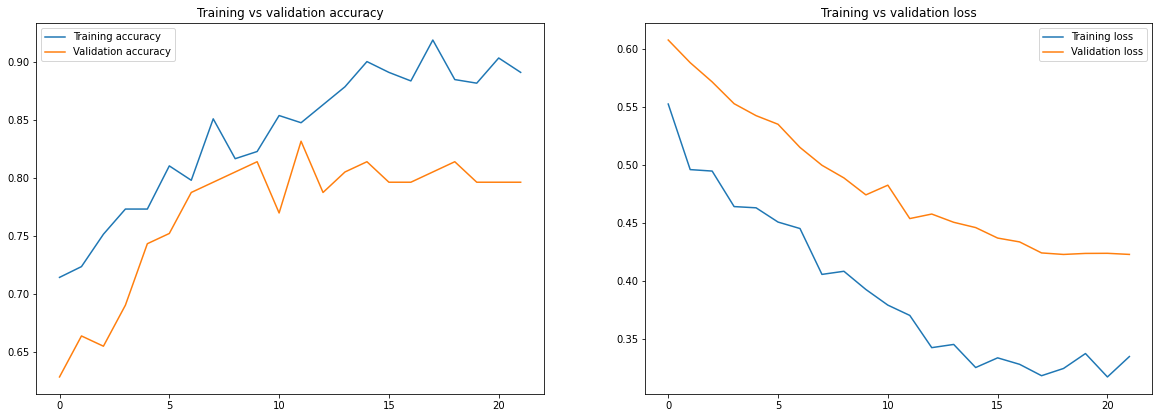

<Figure size 432x288 with 0 Axes>

In [39]:
H_Dense = H16_soft_pre_cate_adam                            ##
pred_Dense = pred_H16_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[56 16]
 [ 7 34]]
Normalized confusion matrix
[[0.78 0.22]
 [0.17 0.83]]


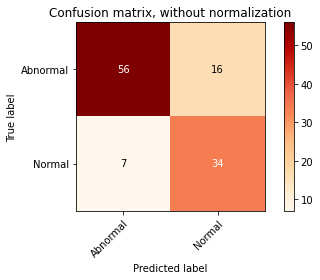

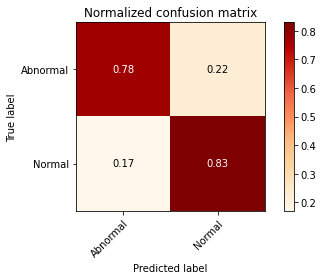

In [40]:
y_pred = pred_H16_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 2.1) K-fold  -- DenseNet201

### -->ACC = 0.85
### -->เวลา 48 นาที

*   BS = 16
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:40<00:00,  2.81it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
BS16 = 16

aug21 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense21 = KFold(5, shuffle=True, random_state=40) 

oos_y21 = []
oos_pred21 = []
fold = 0

for train, test in kf_Dense21.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense21 = data_Dense[train]
    y_train_Dense21 = labels_Dense[train]
    x_test_Dense21 = data_Dense[test]
    y_test_Dense21 = labels_Dense[test]

    H_Dense21 = model_Dense21.fit( x=aug21.flow(x_train_Dense21, y_train_Dense21, batch_size=BS16),
	                                            validation_data=(x_test_Dense21, y_test_Dense21),
	                                            steps_per_epoch=len(x_train_Dense21) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense21 = model_Dense21.predict(x_test_Dense21)
    
    oos_y21.append(y_test_Dense21)
    oos_pred21.append(pred_Dense21)  
    print(classification_report(y_test_Dense21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
22/22 [==============================] - 89s 4s/step - loss: 0.6848 - accuracy: 0.6279 - val_loss: 0.6303 - val_accuracy: 0.7033
Epoch 2/30
22/22 [==============================] - 80s 4s/step - loss: 0.6145 - accuracy: 0.6875 - val_loss: 0.6071 - val_accuracy: 0.6484
Epoch 3/30
22/22 [==============================] - 78s 4s/step - loss: 0.5981 - accuracy: 0.6744 - val_loss: 0.5933 - val_accuracy: 0.6593
Epoch 4/30
22/22 [==============================] - 77s 4s/step - loss: 0.5761 - accuracy: 0.6802 - val_loss: 0.5793 - val_accuracy: 0.6593
              precision    recall  f1-score   support

    Abnormal       0.65      1.00      0.79        58
      Normal       1.00      0.06      0.11        33

    accuracy                           0.66        91
   macro avg       0.83      0.53      0.45        91
weighted avg       0.78      0.66      0.54        91

Fold #2
Epoch 1/30
22/22 [==============================] - 76s 3s/step - loss: 0.5572 - accuracy: 0.6812

In [ ]:
oos_y21 = np.concatenate(oos_y21)
oos_pred21 = np.concatenate(oos_pred21)

In [ ]:
score = metrics.accuracy_score(oos_y21.argmax(axis=1),	        #ค่า acc
                                             oos_pred21.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8514412416851441
              precision    recall  f1-score   support

    Abnormal       0.85      0.94      0.89       300
      Normal       0.84      0.68      0.75       151

    accuracy                           0.85       451
   macro avg       0.85      0.81      0.82       451
weighted avg       0.85      0.85      0.85       451



### training  
- binary_crossentropy
- categorical_crossentropy
- RMSprop 
- Adam

#### 16 pre sig bi
--> 0.68

In [ ]:
BS16 = 16

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)    

aug21 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
(x_train_Dense21, x_test_Dense21, y_train_Dense21, y_test_Dense21 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense21 = model_Dense21.fit( x=aug21.flow(x_train_Dense21, y_train_Dense21, batch_size=BS16),
	                                            validation_data=(x_test_Dense21, y_test_Dense21),
	                                            steps_per_epoch=len(x_train_Dense21) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense21 = model_Dense21.predict(x_test_Dense21)
    
print(classification_report(y_test_Dense21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
21/21 [==============================] - 95s 4s/step - loss: 0.6187 - accuracy: 0.7019 - val_loss: 0.6221 - val_accuracy: 0.6814
Epoch 2/30
21/21 [==============================] - 86s 4s/step - loss: 0.5865 - accuracy: 0.6708 - val_loss: 0.6014 - val_accuracy: 0.6726
Epoch 3/30
21/21 [==============================] - 87s 4s/step - loss: 0.5636 - accuracy: 0.6845 - val_loss: 0.5860 - val_accuracy: 0.6726
Epoch 4/30
21/21 [==============================] - 85s 4s/step - loss: 0.5405 - accuracy: 0.7050 - val_loss: 0.5726 - val_accuracy: 0.6814
              precision    recall  f1-score   support

    Abnormal       0.67      0.99      0.80        72
      Normal       0.86      0.15      0.25        41

    accuracy                           0.68       113
   macro avg       0.76      0.57      0.52       113
weighted avg       0.74      0.68      0.60       113



#### 16 pre sig bi adam
--> 0.

In [ ]:
BS16 = 16

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)    

aug21 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
(x_train_Dense21, x_test_Dense21, y_train_Dense21, y_test_Dense21 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense21 = model_Dense21.fit( x=aug21.flow(x_train_Dense21, y_train_Dense21, batch_size=BS16),
	                                            validation_data=(x_test_Dense21, y_test_Dense21),
	                                            steps_per_epoch=len(x_train_Dense21) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense21 = model_Dense21.predict(x_test_Dense21)
    
print(classification_report(y_test_Dense21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 16 pre sig cate
--> 0.

In [ ]:
BS16 = 16

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)    

aug21 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
(x_train_Dense21, x_test_Dense21, y_train_Dense21, y_test_Dense21 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

H_Dense21 = model_Dense21.fit( x=aug21.flow(x_train_Dense21, y_train_Dense21, batch_size=BS16),
	                                            validation_data=(x_test_Dense21, y_test_Dense21),
	                                            steps_per_epoch=len(x_train_Dense21) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense21 = model_Dense21.predict(x_test_Dense21)
    
print(classification_report(y_test_Dense21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#### 16 pre sig bi adam
--> 0.

In [ ]:
BS16 = 16

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=2)    

aug21 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
(x_train_Dense21, x_test_Dense21, y_train_Dense21, y_test_Dense21 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

H_Dense21 = model_Dense21.fit( x=aug21.flow(x_train_Dense21, y_train_Dense21, batch_size=BS16),
	                                            validation_data=(x_test_Dense21, y_test_Dense21),
	                                            steps_per_epoch=len(x_train_Dense21) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense21 = model_Dense21.predict(x_test_Dense21)
    
print(classification_report(y_test_Dense21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

## 3) K-fold  -- DenseNet201

### -->ACC = 0.89
### -->เวลา 46 นาที

*   BS = 32
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:04<00:00, 96.25it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32
EPOCHS = 50

aug3 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense3 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense3 = KFold(5, shuffle=True, random_state=40) 

oos_y3 = []
oos_pred3 = []
fold = 0

for train, test in kf_Dense3.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense3 = data_Dense[train]
    y_train_Dense3 = labels_Dense[train]
    x_test_Dense3 = data_Dense[test]
    y_test_Dense3 = labels_Dense[test]

    H_Dense3 = model_Dense3.fit( x=aug3.flow(x_train_Dense3, y_train_Dense3, batch_size=BS32),
	                                            validation_data=(x_test_Dense3, y_test_Dense3),
	                                            steps_per_epoch=len(x_train_Dense3) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense3 = model_Dense3.predict(x_test_Dense3)
    
    oos_y3.append(y_test_Dense3)
    oos_pred3.append(pred_Dense3)  
    print(classification_report(y_test_Dense3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))


Fold #1
Epoch 1/30
11/11 [==============================] - 86s 7s/step - loss: 0.7269 - accuracy: 0.6616 - val_loss: 0.7456 - val_accuracy: 0.6044
Epoch 2/30
11/11 [==============================] - 75s 7s/step - loss: 0.7222 - accuracy: 0.6402 - val_loss: 0.7331 - val_accuracy: 0.6154
Epoch 3/30
11/11 [==============================] - 75s 7s/step - loss: 0.7003 - accuracy: 0.6585 - val_loss: 0.7220 - val_accuracy: 0.6154
Epoch 4/30
11/11 [==============================] - 79s 7s/step - loss: 0.6641 - accuracy: 0.6860 - val_loss: 0.7106 - val_accuracy: 0.6264
Epoch 5/30
11/11 [==============================] - 74s 7s/step - loss: 0.6722 - accuracy: 0.6585 - val_loss: 0.6984 - val_accuracy: 0.6264
Epoch 6/30
11/11 [==============================] - 74s 7s/step - loss: 0.6337 - accuracy: 0.6829 - val_loss: 0.6867 - val_accuracy: 0.6264
Epoch 7/30
11/11 [==============================] - 74s 7s/step - loss: 0.6356 - accuracy: 0.6707 - val_loss: 0.6734 - val_accuracy: 0.6264
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Abnormal       0.63      1.00      0.78        57
      Normal       0.00      0.00      0.00        33

    accuracy                           0.63        90
   macro avg       0.32      0.50      0.39        90
weighted avg       0.40      0.63      0.49        90

Fold #4
Epoch 1/30
11/11 [==============================] - 76s 7s/step - loss: 0.5462 - accuracy: 0.6839 - val_loss: 0.5539 - val_accuracy: 0.6667
Epoch 2/30
11/11 [==============================] - 77s 7s/step - loss: 0.5210 - accuracy: 0.6778 - val_loss: 0.5447 - val_accuracy: 0.6889
Epoch 3/30
11/11 [==============================] - 76s 7s/step - loss: 0.5301 - accuracy: 0.6748 - val_loss: 0.5358 - val_accuracy: 0.7222
Epoch 4/30
11/11 [==============================] - 77s 7s/step - loss: 0.5140 - accuracy: 0.7264 - val_loss: 0.5270 - val_accuracy: 0.7333
Epoch 5/30
11/11 [==============================] - 85s 8s/step - loss: 0.5180 - accuracy: 0.7264 - val_l

In [ ]:
oos_y3 = np.concatenate(oos_y3)
oos_pred3 = np.concatenate(oos_pred3)

In [ ]:
score = metrics.accuracy_score(oos_y3.argmax(axis=1),	        #ค่า acc
                                             oos_pred3.argmax(axis=1) )
print(f"Fold score (accuracy): {score}") 

print(classification_report(oos_y3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.7427937915742794
              precision    recall  f1-score   support

    Abnormal       0.72      0.99      0.84       300
      Normal       0.93      0.25      0.40       151

    accuracy                           0.74       451
   macro avg       0.83      0.62      0.62       451
weighted avg       0.79      0.74      0.69       451



### training  
- binary_crossentropy
- categorical_crossentropy
- RMSprop 
- Adam

#### 32  soft pre bi
--> 0.67

In [ ]:
BS = 32                                                       ##
filepath = "model32_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:12<00:00, 35.87it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H32_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H32_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)       

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.7034 - accuracy: 0.5392
Epoch 1: val_accuracy improved from -inf to 0.57522, saving model to model32_soft_pre_bi.h5
10/10 [==============================] - 145s 13s/step - loss: 0.7034 - accuracy: 0.5392 - val_loss: 0.6758 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.6242
Epoch 2: val_accuracy improved from 0.57522 to 0.67257, saving model to model32_soft_pre_bi.h5
10/10 [==============================] - 79s 8s/step - loss: 0.6519 - accuracy: 0.6242 - val_loss: 0.6501 - val_accuracy: 0.6726 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6115 - accuracy: 0.6830
Epoch 3: val_accuracy did not improve from 0.67257
10/10 [==============================] - 79s 8s/step - loss: 0.6115 - accuracy: 0.6830 - val_loss: 0.6314 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 4/100
10/10 [==================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

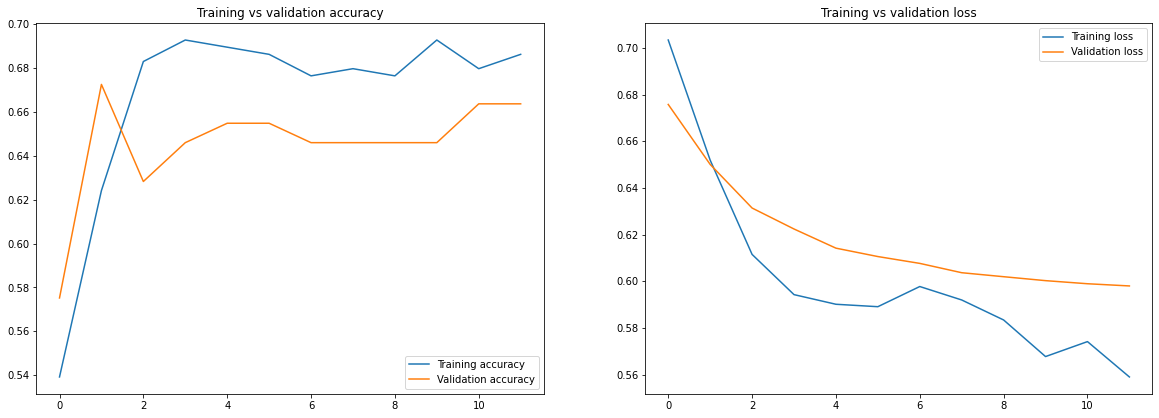

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_bi                            ##
pred_Dense = pred_H32_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[71  1]
 [37  4]]
Normalized confusion matrix
[[0.99 0.01]
 [0.9  0.1 ]]


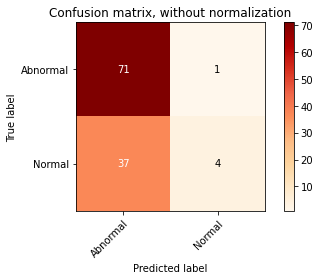

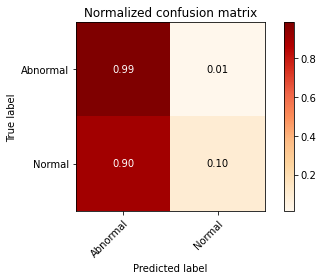

In [ ]:
y_pred = pred_H32_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre bi adam
--> 0.65

In [ ]:
BS = 32                                                      ##
filepath = "model32_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 90.50it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.4739
Epoch 1: val_accuracy improved from -inf to 0.52212, saving model to model32_soft_pre_bi_adam.h5
10/10 [==============================] - 91s 9s/step - loss: 0.7550 - accuracy: 0.4739 - val_loss: 0.7195 - val_accuracy: 0.5221 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.6078
Epoch 2: val_accuracy improved from 0.52212 to 0.57522, saving model to model32_soft_pre_bi_adam.h5
10/10 [==============================] - 82s 8s/step - loss: 0.6990 - accuracy: 0.6078 - val_loss: 0.6774 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6465 - accuracy: 0.6536
Epoch 3: val_accuracy improved from 0.57522 to 0.63717, saving model to model32_soft_pre_bi_adam.h5
10/10 [==============================] - 79s 8s/step - loss: 0.6465 - accuracy: 0.6536 - val_loss: 0.6540 - val_accuracy: 0.63

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

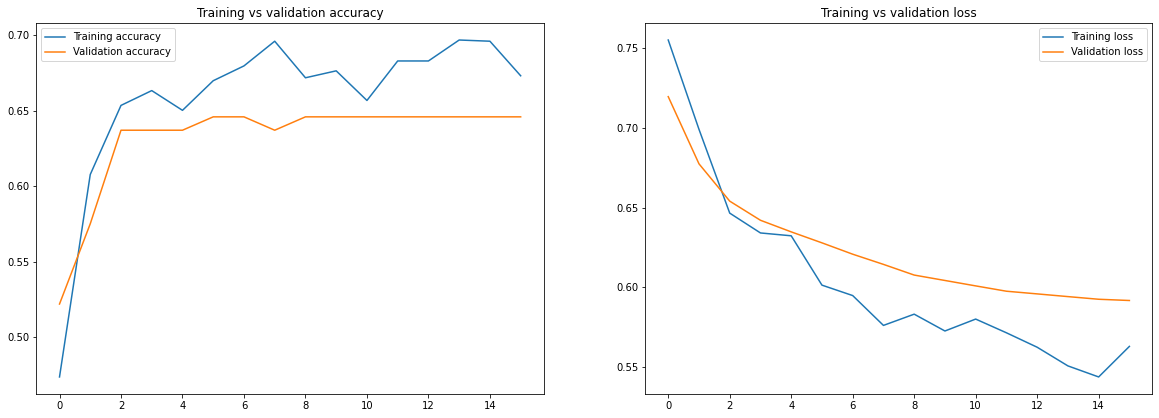

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_bi_adam                            ##
pred_Dense = pred_H32_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[72  0]
 [40  1]]
Normalized confusion matrix
[[1.   0.  ]
 [0.98 0.02]]


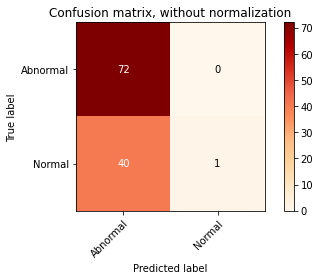

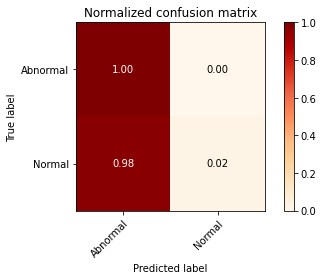

In [ ]:
y_pred = pred_H32_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre cate 
--> 0.81

In [ ]:
BS = 32                                                             ##
filepath = "model32_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 87.72it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.4837
Epoch 1: val_accuracy improved from -inf to 0.63717, saving model to model32_soft_pre_cate.h5
10/10 [==============================] - 105s 10s/step - loss: 0.7401 - accuracy: 0.4837 - val_loss: 0.7274 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.6373
Epoch 2: val_accuracy did not improve from 0.63717
10/10 [==============================] - 89s 9s/step - loss: 0.6697 - accuracy: 0.6373 - val_loss: 0.7082 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.6275
Epoch 3: val_accuracy improved from 0.63717 to 0.64602, saving model to model32_soft_pre_cate.h5
10/10 [==============================] - 90s 9s/step - loss: 0.6736 - accuracy: 0.6275 - val_loss: 0.6893 - val_accuracy: 0.6460 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

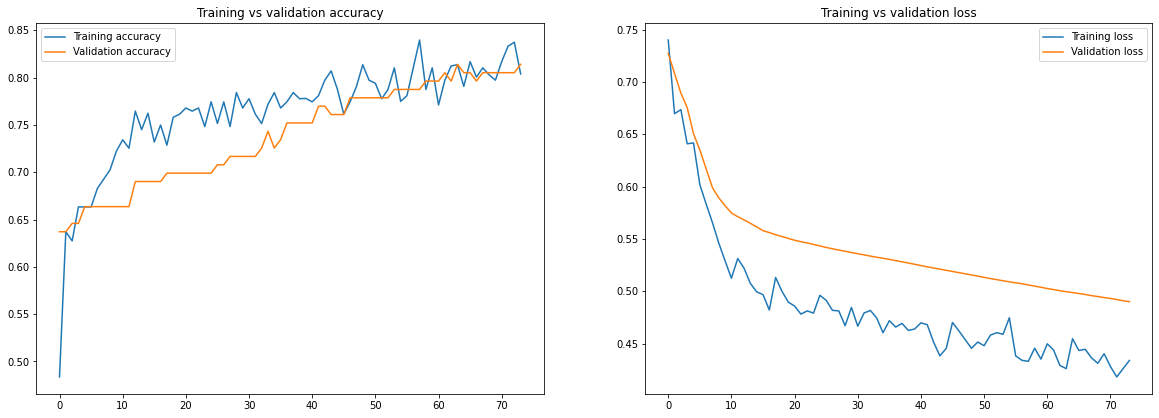

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_cate                            ##
pred_Dense = pred_H32_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[70  2]
 [19 22]]
Normalized confusion matrix
[[0.97 0.03]
 [0.46 0.54]]


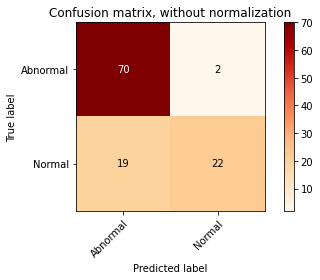

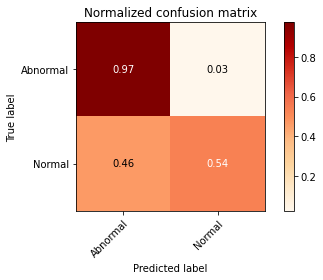

In [ ]:
y_pred = pred_H32_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre cate adam
--> 0.814

In [ ]:
BS = 32                                                       ##
filepath = "model32_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 83.83it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense,  batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.6425 - accuracy: 0.6307
Epoch 1: val_accuracy improved from -inf to 0.57522, saving model to model32_soft_pre_cate_adam.h5
10/10 [==============================] - 108s 10s/step - loss: 0.6425 - accuracy: 0.6307 - val_loss: 0.6789 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6070 - accuracy: 0.6765
Epoch 2: val_accuracy improved from 0.57522 to 0.61062, saving model to model32_soft_pre_cate_adam.h5
10/10 [==============================] - 90s 9s/step - loss: 0.6070 - accuracy: 0.6765 - val_loss: 0.6635 - val_accuracy: 0.6106 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.6765
Epoch 3: val_accuracy did not improve from 0.61062
10/10 [==============================] - 89s 9s/step - loss: 0.6010 - accuracy: 0.6765 - val_loss: 0.6500 - val_accuracy: 0.5929 - lr: 1.0000e-04
Epoch 4/100
10/10 [====

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

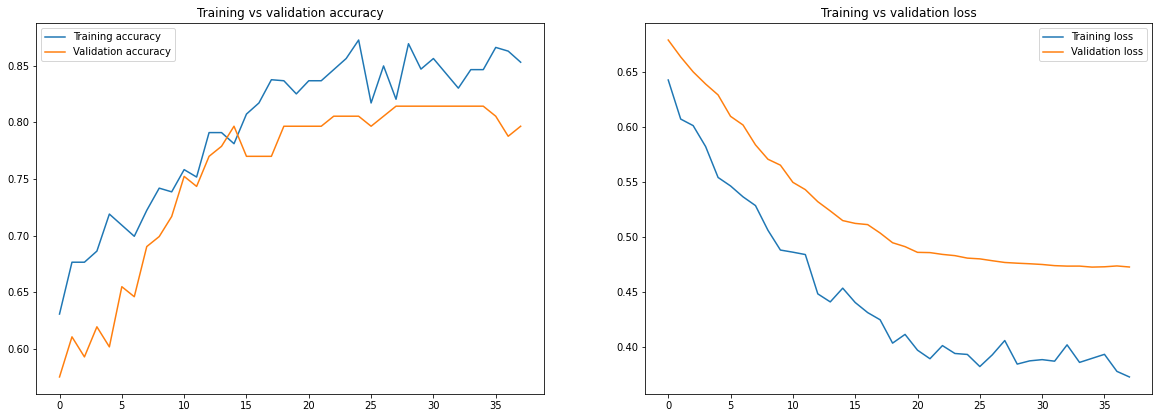

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_cate_adam                            ##
pred_Dense = pred_H32_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[55 17]
 [ 6 35]]
Normalized confusion matrix
[[0.76 0.24]
 [0.15 0.85]]


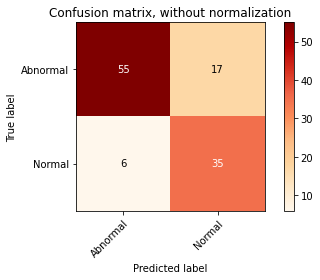

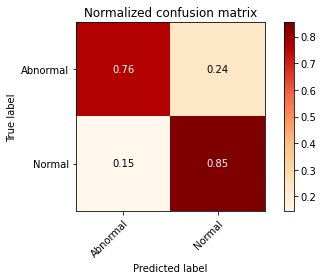

In [ ]:
y_pred = pred_H32_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 3.1) K-fold  -- DenseNet201  

### -->ACC = 0.75
### -->เวลา 39 นาที

*   BS = 32
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:04<00:00, 93.77it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32
EPOCHS = 50

aug31 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)  
model_Dense31 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense31.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

74850304/74836368 [==============================] - 3s 0us/step


In [ ]:
kf_Dense31 = KFold(5, shuffle=True, random_state=40) 

oos_y31 = []
oos_pred31 = []
fold = 0

for train, test in kf_Dense31.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense31 = data_Dense[train]
    y_train_Dense31 = labels_Dense[train]
    x_test_Dense31 = data_Dense[test]
    y_test_Dense31 = labels_Dense[test]

    H_Dense31 = model_Dense31.fit( x=aug31.flow(x_train_Dense31, y_train_Dense31, batch_size=BS32),
	                                            validation_data=(x_test_Dense31, y_test_Dense31),
	                                            steps_per_epoch=len(x_train_Dense31) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense31 = model_Dense31.predict(x_test_Dense31)
    
    oos_y31.append(y_test_Dense31)
    oos_pred31.append(pred_Dense31)  
    print(classification_report(y_test_Dense31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense31.argmax(axis=1),  
                                        target_names=le_Dense.classes_))



Fold #1
Epoch 1/30
11/11 [==============================] - 79s 6s/step - loss: 0.8774 - accuracy: 0.3598 - val_loss: 0.7576 - val_accuracy: 0.4286
Epoch 2/30
11/11 [==============================] - 69s 7s/step - loss: 0.7438 - accuracy: 0.4848 - val_loss: 0.6791 - val_accuracy: 0.7143
Epoch 3/30
11/11 [==============================] - 70s 6s/step - loss: 0.6627 - accuracy: 0.6402 - val_loss: 0.6356 - val_accuracy: 0.7143
Epoch 4/30
11/11 [==============================] - 74s 7s/step - loss: 0.6438 - accuracy: 0.6524 - val_loss: 0.6106 - val_accuracy: 0.7033
Epoch 5/30
11/11 [==============================] - 73s 7s/step - loss: 0.6165 - accuracy: 0.6951 - val_loss: 0.5973 - val_accuracy: 0.6703
              precision    recall  f1-score   support

    Abnormal       0.66      1.00      0.79        58
      Normal       1.00      0.09      0.17        33

    accuracy                           0.67        91
   macro avg       0.83      0.55      0.48        91
weighted avg       0

In [ ]:
oos_y31 = np.concatenate(oos_y31)
oos_pred31 = np.concatenate(oos_pred31)

In [ ]:
score = metrics.accuracy_score(oos_y31.argmax(axis=1),	        #ค่า acc
                                             oos_pred31.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred31.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.7494456762749445
              precision    recall  f1-score   support

    Abnormal       0.73      0.98      0.84       300
      Normal       0.90      0.28      0.43       151

    accuracy                           0.75       451
   macro avg       0.81      0.63      0.64       451
weighted avg       0.79      0.75      0.70       451



### training

In [ ]:
(x_train_Dense31, x_test_Dense31, y_train_Dense31, y_test_Dense31 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense31 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense31.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense31 = model_Dense31.fit( x=aug31.flow(x_train_Dense31, y_train_Dense3, batch_size=BS32),
	                                            validation_data=(x_test_Dense31, y_test_Dense31),
	                                            steps_per_epoch=len(x_train_Dense31) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense31 = model_Dense31.predict(x_test_Dense31)
    
print(classification_report(y_test_Dense31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense31.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
10/10 [==============================] - 91s 8s/step - loss: 0.6665 - accuracy: 0.6531 - val_loss: 0.6763 - val_accuracy: 0.6372
Epoch 2/30
10/10 [==============================] - 76s 8s/step - loss: 0.6248 - accuracy: 0.6830 - val_loss: 0.6676 - val_accuracy: 0.6372
Epoch 3/30
10/10 [==============================] - 77s 8s/step - loss: 0.6158 - accuracy: 0.6895 - val_loss: 0.6595 - val_accuracy: 0.6372
Epoch 4/30
10/10 [==============================] - 77s 8s/step - loss: 0.6148 - accuracy: 0.6687 - val_loss: 0.6475 - val_accuracy: 0.6372
              precision    recall  f1-score   support

    Abnormal       0.64      1.00      0.78        72
      Normal       0.00      0.00      0.00        41

    accuracy                           0.64       113
   macro avg       0.32      0.50      0.39       113
weighted avg       0.41      0.64      0.50       113



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4) K-fold  -- DenseNet201 

### -->ACC = 0.91
### -->เวลา 7988 วินาที

*   BS = 1
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:04<00:00, 102.06it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug4 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense4 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense4.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense4 = KFold(5, shuffle=True, random_state=40) 

oos_y4 = []
oos_pred4 = []
fold = 0

for train, test in kf_Dense4.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense4 = data_Dense[train]
    y_train_Dense4 = labels_Dense[train]
    x_test_Dense4 = data_Dense[test]
    y_test_Dense4 = labels_Dense[test]

    H_Dense4 = model_Dense4.fit( x=aug4.flow(x_train_Dense4, y_train_Dense4, batch_size=BS),
	                                            validation_data=(x_test_Dense4, y_test_Dense4),
	                                            steps_per_epoch=len(x_train_Dense4) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense4 = model_Dense4.predict(x_test_Dense4)
    
    oos_y4.append(y_test_Dense4)
    oos_pred4.append(pred_Dense4)  
    print(classification_report(y_test_Dense4.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense4.argmax(axis=1),  
                                        target_names=le_Dense.classes_))



Fold #1
Epoch 1/30
360/360 [==============================] - 99s 246ms/step - loss: 0.6145 - accuracy: 0.6500 - val_loss: 0.5965 - val_accuracy: 0.6374
Epoch 2/30
360/360 [==============================] - 402s 1s/step - loss: 0.5510 - accuracy: 0.6917 - val_loss: 0.5262 - val_accuracy: 0.7253
Epoch 3/30
360/360 [==============================] - 105s 293ms/step - loss: 0.4875 - accuracy: 0.7278 - val_loss: 0.4894 - val_accuracy: 0.8571
Epoch 4/30
360/360 [==============================] - 484s 1s/step - loss: 0.4326 - accuracy: 0.8139 - val_loss: 0.4517 - val_accuracy: 0.9011
Epoch 5/30
360/360 [==============================] - 543s 2s/step - loss: 0.3958 - accuracy: 0.8472 - val_loss: 0.4174 - val_accuracy: 0.8791
Epoch 6/30
360/360 [==============================] - 480s 1s/step - loss: 0.3812 - accuracy: 0.8250 - val_loss: 0.4222 - val_accuracy: 0.8462
Epoch 7/30
360/360 [==============================] - 224s 621ms/step - loss: 0.3549 - accuracy: 0.8750 - val_loss: 0.3712 - val_

In [ ]:
oos_y4 = np.concatenate(oos_y4)
oos_pred4 = np.concatenate(oos_pred4)

In [ ]:
score = metrics.accuracy_score(oos_y4.argmax(axis=1),	        #ค่า acc
                                             oos_pred4.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y4.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred4.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.9135254988913526
              precision    recall  f1-score   support

    Abnormal       0.97      0.90      0.93       300
      Normal       0.83      0.94      0.88       151

    accuracy                           0.91       451
   macro avg       0.90      0.92      0.91       451
weighted avg       0.92      0.91      0.91       451



### training  
- binary_crossentropy
- categorical_crossentropy
- RMSprop 
- Adam

#### 1  soft pre bi
--> 0.88

In [ ]:
BS = 1                                                      ##
filepath = "model1_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:10<00:00, 44.85it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H1_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
##
pred_H1_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)       

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.7034 - accuracy: 0.6361
Epoch 1: val_accuracy improved from -inf to 0.63717, saving model to model1_soft_pre_bi.h5
338/338 [==============================] - 154s 405ms/step - loss: 0.7034 - accuracy: 0.6361 - val_loss: 0.6832 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.6775
Epoch 2: val_accuracy improved from 0.63717 to 0.64602, saving model to model1_soft_pre_bi.h5
338/338 [==============================] - 164s 485ms/step - loss: 0.5966 - accuracy: 0.6775 - val_loss: 0.6096 - val_accuracy: 0.6460 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.6923
Epoch 3: val_accuracy improved from 0.64602 to 0.68142, saving model to model1_soft_pre_bi.h5
338/338 [==============================] - 186s 551ms/step - loss: 0.5395 - accuracy: 0.6923 - val_loss: 0.5522 - val_accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

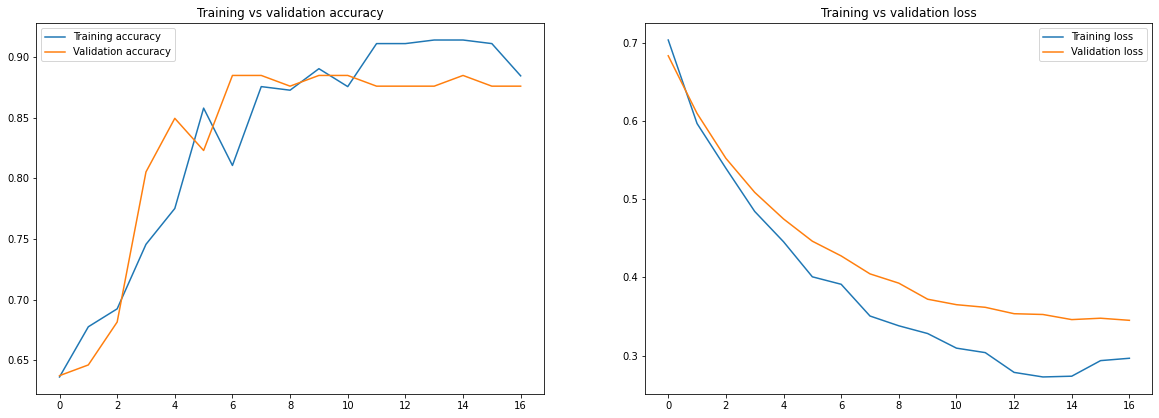

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_bi                            ##
pred_Dense = pred_H1_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[62 10]
 [ 4 37]]
Normalized confusion matrix
[[0.86 0.14]
 [0.1  0.9 ]]


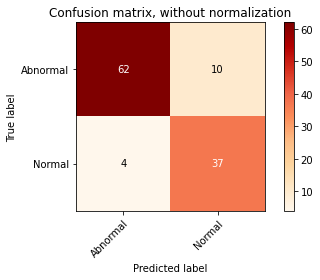

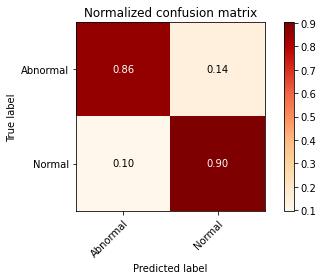

In [ ]:
y_pred = pred_H1_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre bi adam
--> 0.91

In [11]:
BS = 1                                                            ##
filepath = "model1_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [02:08<00:00,  3.50it/s]


In [12]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [13]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.5953 - accuracy: 0.6775
Epoch 1: val_accuracy improved from -inf to 0.63717, saving model to model1_soft_pre_bi_adam.h5
338/338 [==============================] - 59s 106ms/step - loss: 0.5953 - accuracy: 0.6775 - val_loss: 0.5794 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.6953
Epoch 2: val_accuracy improved from 0.63717 to 0.79646, saving model to model1_soft_pre_bi_adam.h5
338/338 [==============================] - 25s 73ms/step - loss: 0.5456 - accuracy: 0.6953 - val_loss: 0.5303 - val_accuracy: 0.7965 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.7663
Epoch 3: val_accuracy improved from 0.79646 to 0.86726, saving model to model1_soft_pre_bi_adam.h5
338/338 [==============================] - 25s 73

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

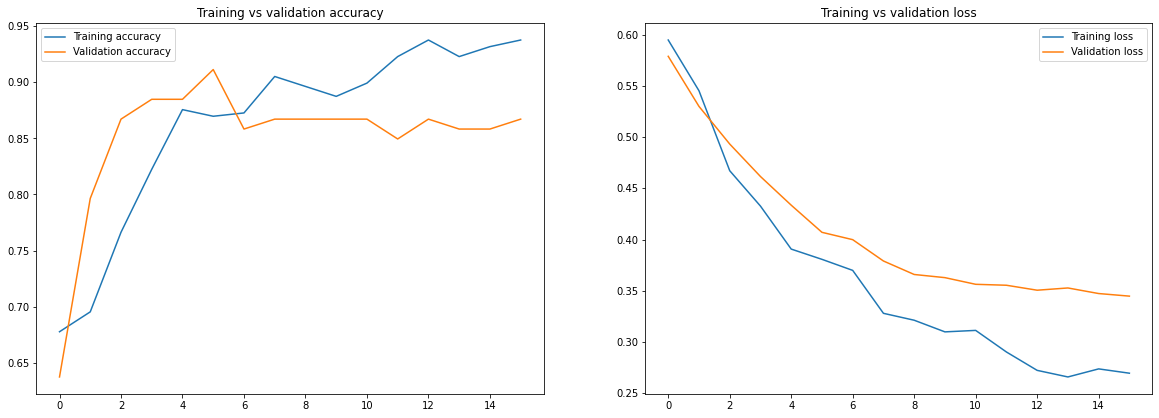

<Figure size 432x288 with 0 Axes>

In [15]:
H_Dense = H1_soft_pre_bi_adam                            ##
pred_Dense = pred_H1_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[61 11]
 [ 4 37]]
Normalized confusion matrix
[[0.85 0.15]
 [0.1  0.9 ]]


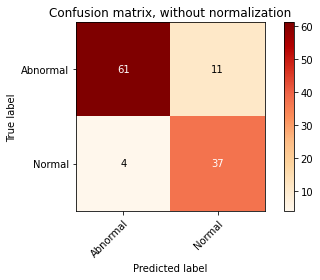

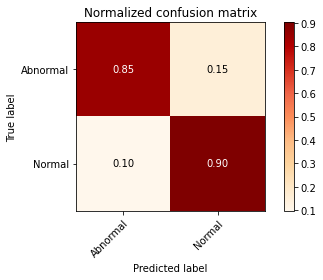

In [16]:
y_pred = pred_H1_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre cate 
--> 0.88

In [17]:
BS = 1                                                             ##
filepath = "mode1_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 83.62it/s] 


In [18]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [19]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.6805
Epoch 1: val_accuracy improved from -inf to 0.78761, saving model to mode1_soft_pre_cate.h5
338/338 [==============================] - 41s 84ms/step - loss: 0.6227 - accuracy: 0.6805 - val_loss: 0.5146 - val_accuracy: 0.7876 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.7485
Epoch 2: val_accuracy improved from 0.78761 to 0.87611, saving model to mode1_soft_pre_cate.h5
338/338 [==============================] - 25s 74ms/step - loss: 0.4933 - accuracy: 0.7485 - val_loss: 0.4353 - val_accuracy: 0.8761 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.8047
Epoch 3: val_accuracy did not improve from 0.87611
338/338 [==============================] - 23s 67ms/step - loss: 0.4120 - accuracy: 0.8047 - val_loss: 0.4213 - val_accuracy: 0.7965 - lr: 1.0000e-04
Epoch 4/100
338/338 [

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

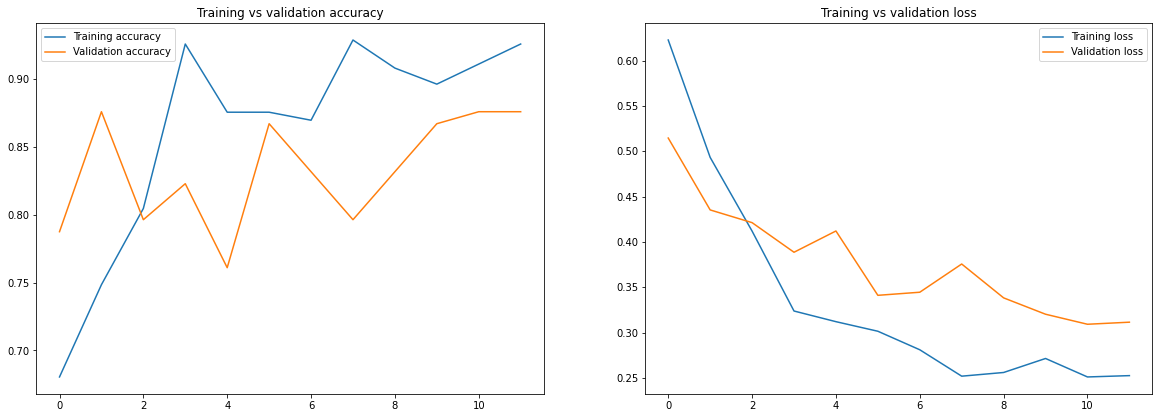

<Figure size 432x288 with 0 Axes>

In [21]:
H_Dense = H1_soft_pre_cate                            ##
pred_Dense = pred_H1_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[61 11]
 [ 3 38]]
Normalized confusion matrix
[[0.85 0.15]
 [0.07 0.93]]


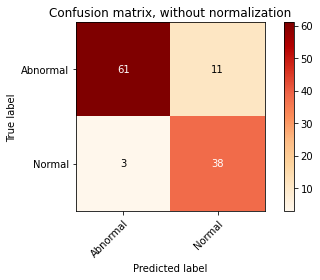

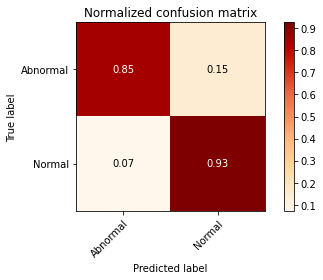

In [22]:
y_pred = pred_H1_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre cate adam
--> 0.92

--> เพิ่ม callbacks 15 ลด lr 5 --> 0.93

In [41]:
BS = 1                                                       ##
filepath = "model1_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:07<00:00, 57.68it/s]


In [42]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [43]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.5957 - accuracy: 0.6775
Epoch 1: val_accuracy improved from -inf to 0.65487, saving model to model1_soft_pre_cate_adam.h5
338/338 [==============================] - 62s 117ms/step - loss: 0.5957 - accuracy: 0.6775 - val_loss: 0.5854 - val_accuracy: 0.6549 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.7663
Epoch 2: val_accuracy improved from 0.65487 to 0.76106, saving model to model1_soft_pre_cate_adam.h5
338/338 [==============================] - 32s 95ms/step - loss: 0.4688 - accuracy: 0.7663 - val_loss: 0.5146 - val_accuracy: 0.7611 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8018
Epoch 3: val_accuracy improved from 0.76106 to 0.82301, saving model to model1_soft_pre_cate_adam.h5
338/338 [==============================] - 25s 75ms/step - loss: 0.4288 - accuracy: 0.8018 - val_loss: 0.466

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

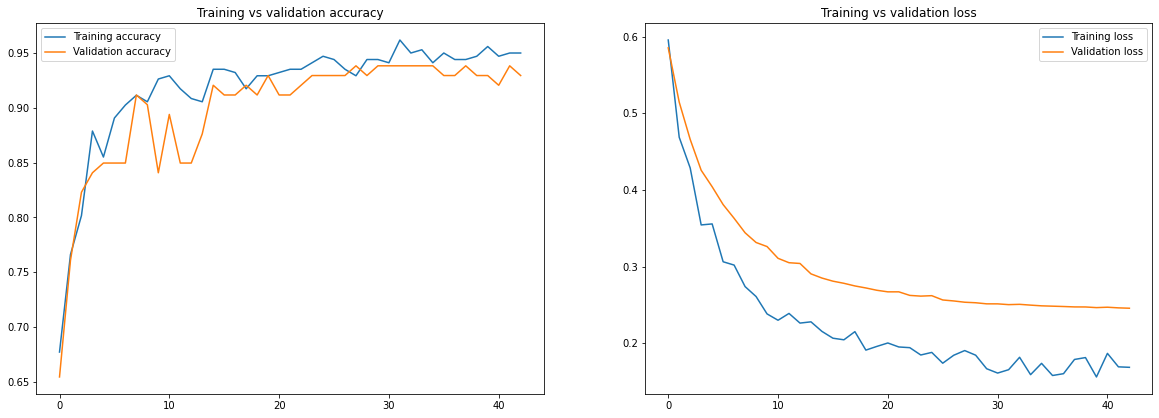

<Figure size 432x288 with 0 Axes>

In [45]:
H_Dense = H1_soft_pre_cate_adam                            ##
pred_Dense = pred_H1_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[70  2]
 [ 6 35]]
Normalized confusion matrix
[[0.97 0.03]
 [0.15 0.85]]


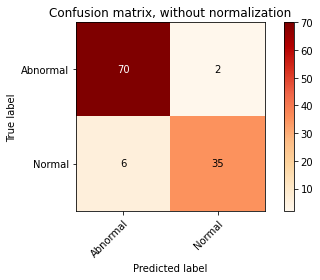

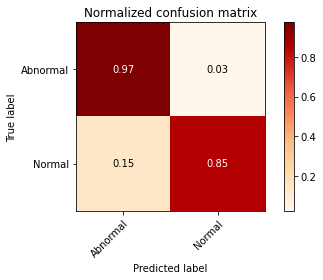

In [46]:
y_pred = pred_H1_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 4.1) K-fold  -- DenseNet201  

### -->ACC = 0.90
### -->เวลา 6299  วินาที 

*   BS = 1
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:15<00:00,  3.34it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug41 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense41 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense41.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
kf_Dense41 = KFold(5, shuffle=True, random_state=40) 

oos_y41 = []
oos_pred41 = []
fold = 0

for train, test in kf_Dense41.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense41 = data_Dense[train]
    y_train_Dense41 = labels_Dense[train]
    x_test_Dense41 = data_Dense[test]
    y_test_Dense41 = labels_Dense[test]

    H_Dense41 = model_Dense41.fit( x=aug41.flow(x_train_Dense41, y_train_Dense41, batch_size=BS),
	                                            validation_data=(x_test_Dense41, y_test_Dense41),
	                                            steps_per_epoch=len(x_train_Dense41) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense41 = model_Dense41.predict(x_test_Dense41)
    
    oos_y41.append(y_test_Dense41)
    oos_pred41.append(pred_Dense41)  
    print(classification_report(y_test_Dense41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))



Fold #1
Epoch 1/30
360/360 [==============================] - 128s 322ms/step - loss: 0.6247 - accuracy: 0.6750 - val_loss: 0.6366 - val_accuracy: 0.6374
Epoch 2/30
360/360 [==============================] - 197s 548ms/step - loss: 0.5556 - accuracy: 0.6889 - val_loss: 0.5993 - val_accuracy: 0.7473
Epoch 3/30
360/360 [==============================] - 197s 549ms/step - loss: 0.4930 - accuracy: 0.7417 - val_loss: 0.5227 - val_accuracy: 0.6923
Epoch 4/30
360/360 [==============================] - 194s 540ms/step - loss: 0.4478 - accuracy: 0.7833 - val_loss: 0.4925 - val_accuracy: 0.8571
Epoch 5/30
360/360 [==============================] - 200s 556ms/step - loss: 0.4245 - accuracy: 0.8306 - val_loss: 0.4548 - val_accuracy: 0.8571
Epoch 6/30
360/360 [==============================] - 184s 511ms/step - loss: 0.3798 - accuracy: 0.8500 - val_loss: 0.4527 - val_accuracy: 0.8571
Epoch 7/30
360/360 [==============================] - 181s 503ms/step - loss: 0.3585 - accuracy: 0.8750 - val_loss: 

In [ ]:
oos_y41 = np.concatenate(oos_y41)
oos_pred41 = np.concatenate(oos_pred41)

In [ ]:
score = metrics.accuracy_score(oos_y41.argmax(axis=1),	        #ค่า acc
                                             oos_pred41.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.9046563192904656
              precision    recall  f1-score   support

    Abnormal       0.97      0.88      0.92       300
      Normal       0.80      0.95      0.87       151

    accuracy                           0.90       451
   macro avg       0.89      0.92      0.90       451
weighted avg       0.91      0.90      0.91       451



### training

In [ ]:
(x_train_Dense41, x_test_Dense41, y_train_Dense41, y_test_Dense41 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense41 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense41.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense41 = model_Dense41.fit( x=aug41.flow(x_train_Dense41, y_train_Dense41, batch_size=BS),
	                                            validation_data=(x_test_Dense41, y_test_Dense41),
	                                            steps_per_epoch=len(x_train_Dense41) // BS,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense41 = model_Dense41.predict(x_test_Dense41)

print(classification_report(y_test_Dense41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
338/338 [==============================] - 115s 309ms/step - loss: 0.6575 - accuracy: 0.6391 - val_loss: 0.6168 - val_accuracy: 0.6372
Epoch 2/30
338/338 [==============================] - 171s 505ms/step - loss: 0.5670 - accuracy: 0.6775 - val_loss: 0.5548 - val_accuracy: 0.6372
Epoch 3/30
338/338 [==============================] - 157s 464ms/step - loss: 0.5162 - accuracy: 0.7071 - val_loss: 0.5083 - val_accuracy: 0.7257
Epoch 4/30
338/338 [==============================] - 175s 517ms/step - loss: 0.4556 - accuracy: 0.7604 - val_loss: 0.4724 - val_accuracy: 0.8761
Epoch 5/30
338/338 [==============================] - 178s 526ms/step - loss: 0.4178 - accuracy: 0.8343 - val_loss: 0.4385 - val_accuracy: 0.8850
Epoch 6/30
338/338 [==============================] - 181s 535ms/step - loss: 0.3891 - accuracy: 0.8550 - val_loss: 0.4134 - val_accuracy: 0.9204
Epoch 7/30
338/338 [==============================] - 174s 515ms/step - loss: 0.3672 - accuracy: 0.8284 - val_loss: 0.3968 -

# Sampling Abnormal

* 50%ของแถวทั้งหมด --> 
df = df.sample(frac=0.50)

* สุ่มแถวเดิมซ้ำกันได้ -->
df = df.sample(n=3,replace=True)

In [ ]:
tabnormal= pd.concat([ttuberculosis, tlungcancer])
tabnormal = tabnormal.sample(n=150, random_state=40)
data_train3 = pd.concat([tnormal, tabnormal])

## 1) K-fold  -- DenseNet201

### -->ACC = 0.86
### -->เวลา 46 นาที

*   BS = 8
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 301/301 [01:19<00:00,  3.80it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS8 = 8
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))



Fold #1
Epoch 1/30
30/30 [==============================] - 80s 2s/step - loss: 0.6565 - accuracy: 0.6917 - val_loss: 0.6818 - val_accuracy: 0.6230
Epoch 2/30
30/30 [==============================] - 66s 2s/step - loss: 0.6347 - accuracy: 0.6917 - val_loss: 0.6590 - val_accuracy: 0.6557
Epoch 3/30
30/30 [==============================] - 66s 2s/step - loss: 0.6227 - accuracy: 0.7292 - val_loss: 0.6405 - val_accuracy: 0.7213
Epoch 4/30
30/30 [==============================] - 66s 2s/step - loss: 0.5922 - accuracy: 0.8083 - val_loss: 0.6263 - val_accuracy: 0.7377
Epoch 5/30
30/30 [==============================] - 65s 2s/step - loss: 0.5862 - accuracy: 0.7917 - val_loss: 0.6109 - val_accuracy: 0.7541
Epoch 6/30
30/30 [==============================] - 66s 2s/step - loss: 0.5639 - accuracy: 0.7917 - val_loss: 0.5956 - val_accuracy: 0.7869
Epoch 7/30
30/30 [==============================] - 66s 2s/step - loss: 0.5381 - accuracy: 0.8667 - val_loss: 0.5836 - val_accuracy: 0.7705
Epoch 8/30
3

In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
score = metrics.accuracy_score(oos_y.argmax(axis=1),	        #ค่า acc
                                             oos_pred.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8571428571428571
              precision    recall  f1-score   support

    Abnormal       0.98      0.73      0.84       150
      Normal       0.78      0.99      0.87       151

    accuracy                           0.86       301
   macro avg       0.88      0.86      0.85       301
weighted avg       0.88      0.86      0.85       301



### training

In [ ]:
(x_train_Dense1, x_test_Dense1, y_train_Dense1, y_test_Dense1 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense1 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense1 = model_Dense1.fit( x=aug.flow(x_train_Dense1, y_train_Dense1, batch_size=BS8),
	                                            validation_data=(x_test_Dense1, y_test_Dense1),
	                                            steps_per_epoch=len(x_train_Dense1) // BS8,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense1 = model_Dense1.predict(x_test_Dense1)
    
print(classification_report(y_test_Dense1.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense1.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
28/28 [==============================] - 89s 3s/step - loss: 0.6954 - accuracy: 0.6406 - val_loss: 0.6515 - val_accuracy: 0.6711
Epoch 2/30
28/28 [==============================] - 87s 3s/step - loss: 0.6504 - accuracy: 0.6473 - val_loss: 0.6404 - val_accuracy: 0.6316
Epoch 3/30
28/28 [==============================] - 88s 3s/step - loss: 0.6300 - accuracy: 0.7419 - val_loss: 0.6273 - val_accuracy: 0.6711
Epoch 4/30
28/28 [==============================] - 90s 3s/step - loss: 0.6194 - accuracy: 0.7143 - val_loss: 0.6092 - val_accuracy: 0.7237
Epoch 5/30
28/28 [==============================] - 109s 4s/step - loss: 0.5853 - accuracy: 0.7926 - val_loss: 0.5921 - val_accuracy: 0.8158
Epoch 6/30
28/28 [==============================] - 109s 4s/step - loss: 0.5764 - accuracy: 0.8157 - val_loss: 0.5806 - val_accuracy: 0.8289
Epoch 7/30
28/28 [==============================] - 112s 4s/step - loss: 0.5644 - accuracy: 0.8387 - val_loss: 0.5767 - val_accuracy: 0.7500
Epoch 8/30
28/28 

## 1.2) K-fold  -- DenseNet201

### -->ACC = 0.83
### -->เวลา 40 นาที

*   BS = 8
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 301/301 [00:07<00:00, 40.27it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS8 = 8
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS8),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS8,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
30/30 [==============================] - 80s 2s/step - loss: 0.6827 - accuracy: 0.6000 - val_loss: 0.6627 - val_accuracy: 0.6557
Epoch 2/30
30/30 [==============================] - 76s 3s/step - loss: 0.6604 - accuracy: 0.6792 - val_loss: 0.6463 - val_accuracy: 0.6721
Epoch 3/30
30/30 [==============================] - 66s 2s/step - loss: 0.6387 - accuracy: 0.7000 - val_loss: 0.6330 - val_accuracy: 0.6885
Epoch 4/30
30/30 [==============================] - 65s 2s/step - loss: 0.6238 - accuracy: 0.7750 - val_loss: 0.6183 - val_accuracy: 0.6885
Epoch 5/30
30/30 [==============================] - 67s 2s/step - loss: 0.6037 - accuracy: 0.7750 - val_loss: 0.6024 - val_accuracy: 0.7049
Epoch 6/30
30/30 [==============================] - 67s 2s/step - loss: 0.5833 - accuracy: 0.8417 - val_loss: 0.5911 - val_accuracy: 0.7049
Epoch 7/30
30/30 [==============================] - 66s 2s/step - loss: 0.5719 - accuracy: 0.8208 - val_loss: 0.5747 - val_accuracy: 0.7377
Epoch 8/30
3

In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
score = metrics.accuracy_score(oos_y.argmax(axis=1),	        #ค่า acc
                                             oos_pred.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8338870431893688
              precision    recall  f1-score   support

    Abnormal       0.97      0.69      0.80       150
      Normal       0.76      0.98      0.86       151

    accuracy                           0.83       301
   macro avg       0.87      0.83      0.83       301
weighted avg       0.86      0.83      0.83       301



### training

In [ ]:
(x_train_Dense11, x_test_Dense11, y_train_Dense11, y_test_Dense11 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense11 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense11.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense11 = model_Dense11.fit( x=aug.flow(x_train_Dense11, y_train_Dense11, batch_size=BS8),
	                                            validation_data=(x_test_Dense11, y_test_Dense11),
	                                            steps_per_epoch=len(x_train_Dense11) // BS8,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense11 = model_Dense11.predict(x_test_Dense11)
    
print(classification_report(y_test_Dense11.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense11.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
28/28 [==============================] - 89s 3s/step - loss: 0.7306 - accuracy: 0.5576 - val_loss: 0.7152 - val_accuracy: 0.5658
Epoch 2/30
28/28 [==============================] - 91s 3s/step - loss: 0.7020 - accuracy: 0.5484 - val_loss: 0.7009 - val_accuracy: 0.6184
Epoch 3/30
28/28 [==============================] - 78s 3s/step - loss: 0.6769 - accuracy: 0.5991 - val_loss: 0.6869 - val_accuracy: 0.6711
Epoch 4/30
28/28 [==============================] - 78s 3s/step - loss: 0.6507 - accuracy: 0.7005 - val_loss: 0.6701 - val_accuracy: 0.6579
Epoch 5/30
28/28 [==============================] - 79s 3s/step - loss: 0.6258 - accuracy: 0.7373 - val_loss: 0.6529 - val_accuracy: 0.6711
Epoch 6/30
28/28 [==============================] - 78s 3s/step - loss: 0.6154 - accuracy: 0.7373 - val_loss: 0.6398 - val_accuracy: 0.6842
Epoch 7/30
28/28 [==============================] - 78s 3s/step - loss: 0.6004 - accuracy: 0.7880 - val_loss: 0.6218 - val_accuracy: 0.7368
Epoch 8/30
28/28 [==

## 2) K-fold  -- DenseNet201

### -->ACC = 0.82
### -->เวลา 50 นาที

*   BS = 16
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 301/301 [00:04<00:00, 72.09it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug2 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   # unit 2
model_Dense2 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense2 = KFold(5, shuffle=True, random_state=40) 

oos_y2 = []
oos_pred2 = []
fold = 0

for train, test in kf_Dense2.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense2 = data_Dense[train]
    y_train_Dense2 = labels_Dense[train]
    x_test_Dense2 = data_Dense[test]
    y_test_Dense2 = labels_Dense[test]

    H_Dense2 = model_Dense2.fit( x=aug2.flow(x_train_Dense2, y_train_Dense2, batch_size=BS16),
	                                            validation_data=(x_test_Dense2, y_test_Dense2),
	                                            steps_per_epoch=len(x_train_Dense2) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
    oos_y2.append(y_test_Dense2)
    oos_pred2.append(pred_Dense2)  
    print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))


Fold #1
Epoch 1/30
15/15 [==============================] - 78s 4s/step - loss: 0.7248 - accuracy: 0.5333 - val_loss: 0.7042 - val_accuracy: 0.5410
Epoch 2/30
15/15 [==============================] - 63s 4s/step - loss: 0.6798 - accuracy: 0.6000 - val_loss: 0.6937 - val_accuracy: 0.5574
Epoch 3/30
15/15 [==============================] - 63s 4s/step - loss: 0.6741 - accuracy: 0.6333 - val_loss: 0.6841 - val_accuracy: 0.6066
Epoch 4/30
15/15 [==============================] - 63s 4s/step - loss: 0.6538 - accuracy: 0.6708 - val_loss: 0.6731 - val_accuracy: 0.6557
Epoch 5/30
15/15 [==============================] - 63s 4s/step - loss: 0.6416 - accuracy: 0.6917 - val_loss: 0.6619 - val_accuracy: 0.6557
Epoch 6/30
15/15 [==============================] - 63s 4s/step - loss: 0.6246 - accuracy: 0.7583 - val_loss: 0.6508 - val_accuracy: 0.7213
Epoch 7/30
15/15 [==============================] - 63s 4s/step - loss: 0.6153 - accuracy: 0.8000 - val_loss: 0.6408 - val_accuracy: 0.7377
Epoch 8/30
1

In [ ]:
oos_y2 = np.concatenate(oos_y2)
oos_pred2 = np.concatenate(oos_pred2)

In [ ]:
score = metrics.accuracy_score(oos_y2.argmax(axis=1),	        #ค่า acc
                                             oos_pred2.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8239202657807309
              precision    recall  f1-score   support

    Abnormal       0.95      0.68      0.79       150
      Normal       0.75      0.97      0.85       151

    accuracy                           0.82       301
   macro avg       0.85      0.82      0.82       301
weighted avg       0.85      0.82      0.82       301



### training
รัน data, labels, data aug ก่อน

In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense2 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense2 = model_Dense2.fit( x=aug2.flow(x_train_Dense2, y_train_Dense2, batch_size=BS16),
	                                            validation_data=(x_test_Dense2, y_test_Dense2),
	                                            steps_per_epoch=len(x_train_Dense2) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
14/14 [==============================] - 93s 6s/step - loss: 0.7322 - accuracy: 0.4976 - val_loss: 0.6871 - val_accuracy: 0.5921
Epoch 2/30
14/14 [==============================] - 78s 6s/step - loss: 0.7042 - accuracy: 0.5263 - val_loss: 0.6742 - val_accuracy: 0.6316
Epoch 3/30
14/14 [==============================] - 78s 6s/step - loss: 0.6869 - accuracy: 0.6029 - val_loss: 0.6658 - val_accuracy: 0.6579
Epoch 4/30
14/14 [==============================] - 82s 6s/step - loss: 0.6766 - accuracy: 0.5759 - val_loss: 0.6570 - val_accuracy: 0.6711
Epoch 5/30
14/14 [==============================] - 76s 6s/step - loss: 0.6654 - accuracy: 0.5933 - val_loss: 0.6489 - val_accuracy: 0.7368
Epoch 6/30
14/14 [==============================] - 78s 6s/step - loss: 0.6631 - accuracy: 0.6459 - val_loss: 0.6405 - val_accuracy: 0.7632
Epoch 7/30
14/14 [==============================] - 74s 5s/step - loss: 0.6391 - accuracy: 0.6268 - val_loss: 0.6310 - val_accuracy: 0.8026
Epoch 8/30
14/14 [==

## 2.1) K-fold  -- DenseNet201 + train



### -->ACC = 0.76
### -->เวลา 41 นาที

*   BS = 16
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 301/301 [01:34<00:00,  3.17it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug21 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
kf_Dense21 = KFold(5, shuffle=True, random_state=40) 

oos_y21 = []
oos_pred21 = []
fold = 0

for train, test in kf_Dense21.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense21 = data_Dense[train]
    y_train_Dense21 = labels_Dense[train]
    x_test_Dense21 = data_Dense[test]
    y_test_Dense21 = labels_Dense[test]

    H_Dense21 = model_Dense21.fit( x=aug21.flow(x_train_Dense21, y_train_Dense21, batch_size=BS16),
	                                            validation_data=(x_test_Dense21, y_test_Dense21),
	                                            steps_per_epoch=len(x_train_Dense21) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense21 = model_Dense21.predict(x_test_Dense21)
    
    oos_y21.append(y_test_Dense21)
    oos_pred21.append(pred_Dense21)  
    print(classification_report(y_test_Dense21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
15/15 [==============================] - 83s 5s/step - loss: 0.7444 - accuracy: 0.5083 - val_loss: 0.6973 - val_accuracy: 0.5574
Epoch 2/30
15/15 [==============================] - 66s 4s/step - loss: 0.7038 - accuracy: 0.5417 - val_loss: 0.6751 - val_accuracy: 0.5574
Epoch 3/30
15/15 [==============================] - 67s 4s/step - loss: 0.6729 - accuracy: 0.6250 - val_loss: 0.6596 - val_accuracy: 0.6230
Epoch 4/30
15/15 [==============================] - 67s 5s/step - loss: 0.6621 - accuracy: 0.6417 - val_loss: 0.6467 - val_accuracy: 0.6721
Epoch 5/30
15/15 [==============================] - 68s 5s/step - loss: 0.6584 - accuracy: 0.6167 - val_loss: 0.6357 - val_accuracy: 0.6721
Epoch 6/30
15/15 [==============================] - 68s 5s/step - loss: 0.6371 - accuracy: 0.7250 - val_loss: 0.6261 - val_accuracy: 0.6721
Epoch 7/30
15/15 [==============================] - 67s 4s/step - loss: 0.6246 - accuracy: 0.7375 - val_loss: 0.6138 - val_accuracy: 0.7541
Epoch 8/30
1

In [ ]:
oos_y21 = np.concatenate(oos_y21)
oos_pred21 = np.concatenate(oos_pred21)

In [ ]:
score = metrics.accuracy_score(oos_y21.argmax(axis=1),	        #ค่า acc
                                             oos_pred21.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.7574750830564784
              precision    recall  f1-score   support

    Abnormal       0.96      0.53      0.69       150
      Normal       0.68      0.98      0.80       151

    accuracy                           0.76       301
   macro avg       0.82      0.76      0.74       301
weighted avg       0.82      0.76      0.74       301



### training

In [ ]:
(x_train_Dense21, x_test_Dense21, y_train_Dense21, y_test_Dense21 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense21 = model_Dense21.fit( x=aug21.flow(x_train_Dense21, y_train_Dense21, batch_size=BS16),
	                                            validation_data=(x_test_Dense21, y_test_Dense21),
	                                            steps_per_epoch=len(x_train_Dense21) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense21 = model_Dense21.predict(x_test_Dense21)
    
print(classification_report(y_test_Dense21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
14/14 [==============================] - 83s 5s/step - loss: 0.7892 - accuracy: 0.3636 - val_loss: 0.7305 - val_accuracy: 0.4079
Epoch 2/30
14/14 [==============================] - 70s 5s/step - loss: 0.7597 - accuracy: 0.4019 - val_loss: 0.7133 - val_accuracy: 0.4605
Epoch 3/30
14/14 [==============================] - 72s 5s/step - loss: 0.7294 - accuracy: 0.4258 - val_loss: 0.7041 - val_accuracy: 0.4868
Epoch 4/30
14/14 [==============================] - 72s 5s/step - loss: 0.7212 - accuracy: 0.4450 - val_loss: 0.6899 - val_accuracy: 0.5132
Epoch 5/30
14/14 [==============================] - 71s 5s/step - loss: 0.7187 - accuracy: 0.4880 - val_loss: 0.6780 - val_accuracy: 0.5789
Epoch 6/30
14/14 [==============================] - 71s 5s/step - loss: 0.6958 - accuracy: 0.5215 - val_loss: 0.6711 - val_accuracy: 0.5921
Epoch 7/30
14/14 [==============================] - 75s 5s/step - loss: 0.6869 - accuracy: 0.5759 - val_loss: 0.6591 - val_accuracy: 0.6184
Epoch 8/30
14/14 [==

## 3) K-fold  -- DenseNet201 + train

### -->ACC = 0.83
### -->เวลา 46 นาที

*   BS = 32
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 301/301 [02:19<00:00,  2.16it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32
EPOCHS = 50

aug3 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense3 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
kf_Dense3 = KFold(5, shuffle=True, random_state=40) 

oos_y3 = []
oos_pred3 = []
fold = 0

for train, test in kf_Dense3.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense3 = data_Dense[train]
    y_train_Dense3 = labels_Dense[train]
    x_test_Dense3 = data_Dense[test]
    y_test_Dense3 = labels_Dense[test]

    H_Dense3 = model_Dense3.fit( x=aug3.flow(x_train_Dense3, y_train_Dense3, batch_size=BS32),
	                                            validation_data=(x_test_Dense3, y_test_Dense3),
	                                            steps_per_epoch=len(x_train_Dense3) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense3 = model_Dense3.predict(x_test_Dense3)
    
    oos_y3.append(y_test_Dense3)
    oos_pred3.append(pred_Dense3)  
    print(classification_report(y_test_Dense3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))


Fold #1
Epoch 1/30
7/7 [==============================] - 69s 8s/step - loss: 0.7438 - accuracy: 0.4286 - val_loss: 0.7167 - val_accuracy: 0.4426
Epoch 2/30
7/7 [==============================] - 55s 8s/step - loss: 0.7055 - accuracy: 0.5089 - val_loss: 0.7080 - val_accuracy: 0.4262
Epoch 3/30
7/7 [==============================] - 55s 8s/step - loss: 0.7176 - accuracy: 0.4821 - val_loss: 0.6967 - val_accuracy: 0.4426
Epoch 4/30
7/7 [==============================] - 56s 8s/step - loss: 0.7058 - accuracy: 0.4777 - val_loss: 0.6864 - val_accuracy: 0.5082
Epoch 5/30
7/7 [==============================] - 55s 8s/step - loss: 0.6929 - accuracy: 0.5402 - val_loss: 0.6802 - val_accuracy: 0.5246
Epoch 6/30
7/7 [==============================] - 53s 8s/step - loss: 0.6778 - accuracy: 0.6346 - val_loss: 0.6708 - val_accuracy: 0.5738
Epoch 7/30
7/7 [==============================] - 53s 8s/step - loss: 0.6722 - accuracy: 0.6394 - val_loss: 0.6635 - val_accuracy: 0.6066
Epoch 8/30
7/7 [==========

In [ ]:
oos_y3 = np.concatenate(oos_y3)
oos_pred3 = np.concatenate(oos_pred3)

In [ ]:
score = metrics.accuracy_score(oos_y3.argmax(axis=1),	        #ค่า acc
                                             oos_pred3.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8338870431893688
              precision    recall  f1-score   support

    Abnormal       0.89      0.76      0.82       150
      Normal       0.79      0.91      0.85       151

    accuracy                           0.83       301
   macro avg       0.84      0.83      0.83       301
weighted avg       0.84      0.83      0.83       301



### training

In [ ]:
(x_train_Dense3, x_test_Dense3, y_train_Dense3, y_test_Dense3 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense3 = model_Dense3.fit( x=aug3.flow(x_train_Dense3, y_train_Dense3, batch_size=BS32),
	                                            validation_data=(x_test_Dense3, y_test_Dense3),
	                                            steps_per_epoch=len(x_train_Dense3) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense3 = model_Dense3.predict(x_test_Dense3)
    
print(classification_report(y_test_Dense3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
7/7 [==============================] - 56s 8s/step - loss: 0.4772 - accuracy: 0.8653 - val_loss: 0.4843 - val_accuracy: 0.8816
Epoch 2/30
7/7 [==============================] - 58s 9s/step - loss: 0.4672 - accuracy: 0.8750 - val_loss: 0.4811 - val_accuracy: 0.8816
Epoch 3/30
7/7 [==============================] - 52s 9s/step - loss: 0.4797 - accuracy: 0.8653 - val_loss: 0.4794 - val_accuracy: 0.8947
Epoch 4/30
7/7 [==============================] - 52s 8s/step - loss: 0.4694 - accuracy: 0.8756 - val_loss: 0.4778 - val_accuracy: 0.8947
Epoch 5/30
7/7 [==============================] - 52s 8s/step - loss: 0.4719 - accuracy: 0.8446 - val_loss: 0.4733 - val_accuracy: 0.8816
Epoch 6/30
7/7 [==============================] - 52s 8s/step - loss: 0.4623 - accuracy: 0.8912 - val_loss: 0.4718 - val_accuracy: 0.8816
              precision    recall  f1-score   support

    Abnormal       0.89      0.86      0.87        36
      Normal       0.88      0.90      0.89        40

    accu

## 3.1) K-fold  -- DenseNet201  

### -->ACC = 0.87
### -->เวลา 43 นาที

*   BS = 32
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 301/301 [00:03<00:00, 87.50it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32
EPOCHS = 50

aug31 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)  
model_Dense31 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense31.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense31 = KFold(5, shuffle=True, random_state=40) 

oos_y31 = []
oos_pred31 = []
fold = 0

for train, test in kf_Dense31.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense31 = data_Dense[train]
    y_train_Dense31 = labels_Dense[train]
    x_test_Dense31 = data_Dense[test]
    y_test_Dense31 = labels_Dense[test]

    H_Dense31 = model_Dense31.fit( x=aug31.flow(x_train_Dense31, y_train_Dense31, batch_size=BS32),
	                                            validation_data=(x_test_Dense31, y_test_Dense31),
	                                            steps_per_epoch=len(x_train_Dense31) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense31 = model_Dense31.predict(x_test_Dense31)
    
    oos_y31.append(y_test_Dense31)
    oos_pred31.append(pred_Dense31)  
    print(classification_report(y_test_Dense31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense31.argmax(axis=1),  
                                        target_names=le_Dense.classes_))



Fold #1
Epoch 1/30
7/7 [==============================] - 55s 9s/step - loss: 0.5988 - accuracy: 0.7404 - val_loss: 0.6372 - val_accuracy: 0.6393
Epoch 2/30
7/7 [==============================] - 55s 8s/step - loss: 0.6014 - accuracy: 0.7644 - val_loss: 0.6338 - val_accuracy: 0.6557
Epoch 3/30
7/7 [==============================] - 56s 8s/step - loss: 0.5919 - accuracy: 0.7788 - val_loss: 0.6304 - val_accuracy: 0.6721
Epoch 4/30
7/7 [==============================] - 55s 8s/step - loss: 0.5852 - accuracy: 0.7692 - val_loss: 0.6219 - val_accuracy: 0.6885
Epoch 5/30
7/7 [==============================] - 62s 9s/step - loss: 0.5854 - accuracy: 0.7723 - val_loss: 0.6166 - val_accuracy: 0.6885
Epoch 6/30
7/7 [==============================] - 55s 8s/step - loss: 0.5811 - accuracy: 0.7596 - val_loss: 0.6096 - val_accuracy: 0.7541
Epoch 7/30
7/7 [==============================] - 56s 8s/step - loss: 0.5674 - accuracy: 0.8077 - val_loss: 0.6033 - val_accuracy: 0.7705
Epoch 8/30
7/7 [==========

In [ ]:
oos_y31 = np.concatenate(oos_y31)
oos_pred31 = np.concatenate(oos_pred31)

In [ ]:
score = metrics.accuracy_score(oos_y31.argmax(axis=1),	        #ค่า acc
                                             oos_pred31.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred31.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8737541528239202
              precision    recall  f1-score   support

    Abnormal       0.92      0.81      0.87       150
      Normal       0.83      0.93      0.88       151

    accuracy                           0.87       301
   macro avg       0.88      0.87      0.87       301
weighted avg       0.88      0.87      0.87       301



### training

In [ ]:
(x_train_Dense31, x_test_Dense31, y_train_Dense31, y_test_Dense31 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense31 = model_Dense31.fit( x=aug31.flow(x_train_Dense31, y_train_Dense31, batch_size=BS32),
	                                            validation_data=(x_test_Dense31, y_test_Dense31),
	                                            steps_per_epoch=len(x_train_Dense31) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense31 = model_Dense31.predict(x_test_Dense31)

print(classification_report(y_test_Dense31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense31.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
7/7 [==============================] - 53s 8s/step - loss: 0.4253 - accuracy: 0.8860 - val_loss: 0.4643 - val_accuracy: 0.8947
Epoch 2/30
7/7 [==============================] - 53s 8s/step - loss: 0.4315 - accuracy: 0.8601 - val_loss: 0.4605 - val_accuracy: 0.8684
Epoch 4/30
7/7 [==============================] - 59s 9s/step - loss: 0.4106 - accuracy: 0.9196 - val_loss: 0.4582 - val_accuracy: 0.8816
              precision    recall  f1-score   support

    Abnormal       0.94      0.81      0.87        36
      Normal       0.84      0.95      0.89        40

    accuracy                           0.88        76
   macro avg       0.89      0.88      0.88        76
weighted avg       0.89      0.88      0.88        76



## 4) K-fold  -- DenseNet201 

### -->ACC = 0.90
### -->เวลา 41 นาที

*   BS = 1
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 301/301 [00:03<00:00, 85.85it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug4 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense4 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense4.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense4 = KFold(5, shuffle=True, random_state=40) 

oos_y4 = []
oos_pred4 = []
fold = 0

for train, test in kf_Dense4.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense4 = data_Dense[train]
    y_train_Dense4 = labels_Dense[train]
    x_test_Dense4 = data_Dense[test]
    y_test_Dense4 = labels_Dense[test]

    H_Dense4 = model_Dense4.fit( x=aug4.flow(x_train_Dense4, y_train_Dense4, batch_size=BS),
	                                            validation_data=(x_test_Dense4, y_test_Dense4),
	                                            steps_per_epoch=len(x_train_Dense4) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense4 = model_Dense4.predict(x_test_Dense4)
    
    oos_y4.append(y_test_Dense4)
    oos_pred4.append(pred_Dense4)  
    print(classification_report(y_test_Dense4.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense4.argmax(axis=1),  
                                        target_names=le_Dense.classes_))



Fold #1
Epoch 1/30
240/240 [==============================] - 83s 297ms/step - loss: 0.7114 - accuracy: 0.5167 - val_loss: 0.6949 - val_accuracy: 0.5246
Epoch 2/30
240/240 [==============================] - 72s 302ms/step - loss: 0.6453 - accuracy: 0.6458 - val_loss: 0.6473 - val_accuracy: 0.6721
Epoch 3/30
240/240 [==============================] - 72s 299ms/step - loss: 0.5852 - accuracy: 0.7500 - val_loss: 0.6042 - val_accuracy: 0.7377
Epoch 4/30
240/240 [==============================] - 68s 285ms/step - loss: 0.5332 - accuracy: 0.8083 - val_loss: 0.5854 - val_accuracy: 0.6557
Epoch 5/30
240/240 [==============================] - 73s 305ms/step - loss: 0.5051 - accuracy: 0.8125 - val_loss: 0.5347 - val_accuracy: 0.8197
Epoch 6/30
240/240 [==============================] - 67s 278ms/step - loss: 0.4822 - accuracy: 0.8208 - val_loss: 0.5091 - val_accuracy: 0.8197
Epoch 7/30
240/240 [==============================] - 67s 279ms/step - loss: 0.4493 - accuracy: 0.8542 - val_loss: 0.4842 

In [ ]:
oos_y4 = np.concatenate(oos_y4)
oos_pred4 = np.concatenate(oos_pred4)

In [ ]:
score = metrics.accuracy_score(oos_y4.argmax(axis=1),	        #ค่า acc
                                             oos_pred4.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y4.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred4.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.9036544850498339
              precision    recall  f1-score   support

    Abnormal       0.96      0.84      0.90       150
      Normal       0.86      0.97      0.91       151

    accuracy                           0.90       301
   macro avg       0.91      0.90      0.90       301
weighted avg       0.91      0.90      0.90       301



### training

In [ ]:
(x_train_Dense4, x_test_Dense4, y_train_Dense4, y_test_Dense4 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense4 = model_Dense4.fit( x=aug4.flow(x_train_Dense4, y_train_Dense4, batch_size=BS),
	                                            validation_data=(x_test_Dense4, y_test_Dense4),
	                                            steps_per_epoch=len(x_train_Dense4) // BS,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense4 = model_Dense4.predict(x_test_Dense4)

print(classification_report(y_test_Dense4.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense4.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
225/225 [==============================] - 65s 290ms/step - loss: 0.2293 - accuracy: 0.8978 - val_loss: 0.2589 - val_accuracy: 0.8947
Epoch 2/30
225/225 [==============================] - 65s 289ms/step - loss: 0.2401 - accuracy: 0.9200 - val_loss: 0.2514 - val_accuracy: 0.8816
Epoch 3/30
225/225 [==============================] - 65s 289ms/step - loss: 0.2360 - accuracy: 0.9156 - val_loss: 0.2525 - val_accuracy: 0.8947
Epoch 4/30
225/225 [==============================] - 65s 289ms/step - loss: 0.2382 - accuracy: 0.9111 - val_loss: 0.2530 - val_accuracy: 0.8947
              precision    recall  f1-score   support

    Abnormal       0.97      0.81      0.88        36
      Normal       0.85      0.97      0.91        40

    accuracy                           0.89        76
   macro avg       0.91      0.89      0.89        76
weighted avg       0.90      0.89      0.89        76



## 4.1) K-fold  -- DenseNet201  

### -->ACC = 0.88
### -->เวลา  41 นาที 

*   BS = 1
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

### K-fold

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 301/301 [00:03<00:00, 89.64it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=2)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug41 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense41 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense41.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense41 = KFold(5, shuffle=True, random_state=40) 

oos_y41 = []
oos_pred41 = []
fold = 0

for train, test in kf_Dense41.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense41 = data_Dense[train]
    y_train_Dense41 = labels_Dense[train]
    x_test_Dense41 = data_Dense[test]
    y_test_Dense41 = labels_Dense[test]

    H_Dense41 = model_Dense41.fit( x=aug41.flow(x_train_Dense41, y_train_Dense41, batch_size=BS),
	                                            validation_data=(x_test_Dense41, y_test_Dense41),
	                                            steps_per_epoch=len(x_train_Dense41) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense41 = model_Dense41.predict(x_test_Dense41)
    
    oos_y41.append(y_test_Dense41)
    oos_pred41.append(pred_Dense41)  
    print(classification_report(y_test_Dense41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))



Fold #1
Epoch 1/30
240/240 [==============================] - 83s 302ms/step - loss: 0.7173 - accuracy: 0.4958 - val_loss: 0.6771 - val_accuracy: 0.6721
Epoch 2/30
240/240 [==============================] - 73s 305ms/step - loss: 0.6460 - accuracy: 0.6583 - val_loss: 0.6367 - val_accuracy: 0.6393
Epoch 3/30
240/240 [==============================] - 73s 305ms/step - loss: 0.5952 - accuracy: 0.7458 - val_loss: 0.6052 - val_accuracy: 0.6721
Epoch 4/30
240/240 [==============================] - 74s 308ms/step - loss: 0.5418 - accuracy: 0.8208 - val_loss: 0.5571 - val_accuracy: 0.7541
Epoch 5/30
240/240 [==============================] - 73s 305ms/step - loss: 0.5160 - accuracy: 0.8417 - val_loss: 0.5269 - val_accuracy: 0.8361
Epoch 6/30
240/240 [==============================] - 73s 305ms/step - loss: 0.4716 - accuracy: 0.8583 - val_loss: 0.5046 - val_accuracy: 0.7869
Epoch 7/30
240/240 [==============================] - 74s 307ms/step - loss: 0.4503 - accuracy: 0.8625 - val_loss: 0.4860 

In [ ]:
oos_y41 = np.concatenate(oos_y41)
oos_pred41 = np.concatenate(oos_pred41)

In [ ]:
score = metrics.accuracy_score(oos_y41.argmax(axis=1),	        #ค่า acc
                                             oos_pred41.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8837209302325582
              precision    recall  f1-score   support

    Abnormal       0.98      0.78      0.87       150
      Normal       0.82      0.99      0.89       151

    accuracy                           0.88       301
   macro avg       0.90      0.88      0.88       301
weighted avg       0.90      0.88      0.88       301



### training

In [ ]:
(x_train_Dense41, x_test_Dense41, y_train_Dense41, y_test_Dense41 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Dense41 = model_Dense41.fit( x=aug41.flow(x_train_Dense41, y_train_Dense41, batch_size=BS),
	                                            validation_data=(x_test_Dense41, y_test_Dense41),
	                                            steps_per_epoch=len(x_train_Dense41) // BS,
	                                            epochs=30,  callbacks = [callback])
    
pred_Dense41 = model_Dense41.predict(x_test_Dense41)

print(classification_report(y_test_Dense41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
225/225 [==============================] - 67s 299ms/step - loss: 0.2212 - accuracy: 0.9067 - val_loss: 0.2660 - val_accuracy: 0.9079
Epoch 2/30
225/225 [==============================] - 67s 298ms/step - loss: 0.2274 - accuracy: 0.9156 - val_loss: 0.2594 - val_accuracy: 0.9079
Epoch 3/30
225/225 [==============================] - 94s 418ms/step - loss: 0.2184 - accuracy: 0.9378 - val_loss: 0.2576 - val_accuracy: 0.9079
Epoch 4/30
225/225 [==============================] - 67s 300ms/step - loss: 0.2363 - accuracy: 0.9111 - val_loss: 0.2510 - val_accuracy: 0.9079
              precision    recall  f1-score   support

    Abnormal       0.97      0.83      0.90        36
      Normal       0.87      0.97      0.92        40

    accuracy                           0.91        76
   macro avg       0.92      0.90      0.91        76
weighted avg       0.91      0.91      0.91        76



# ลอง predict

In [ ]:
model_Dense41

In [ ]:
import pickle

In [ ]:
pickle.dump(model_Dense41, open('model_Dense41.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://bcb8f0ce-07c6-4313-8fba-7950ce12a174/assets


In [ ]:
loaded_model = pickle.load(open('model_Dense41.pkl', 'rb'))

In [ ]:
loaded_model.predict(data_pred)

array([[0.9822429 , 0.01927125],
       [0.9822429 , 0.01927125],
       [0.9822429 , 0.01927125]], dtype=float32)

In [ ]:
ttest = []
img = cv2.imread(All_3class_dir + '/tb41.jpg')                                            # อ่านรูป
img = cv2.resize(img, (224, 224))

img2 = cv2.imread(All_3class_dir + '/34.jpg')                                            # อ่านรูป
img2 = cv2.resize(img, (224, 224))

img3 = cv2.imread(All_3class_dir + '/94.jpg')                                            # อ่านรูป
img3 = cv2.resize(img, (224, 224))


ttest.append(img)

In [ ]:
ttest.append(img2)
ttest.append(img3)

data_pred = np.array(ttest, dtype="float32") / 255.0
data_pred.shape

(3, 224, 224, 3)

In [ ]:
le_Dense.classes_

array(['Abnormal', 'Normal'], dtype=object)

In [ ]:
pred= model_Dense41.predict(data_pred)

In [ ]:
pred

array([[0.9822428 , 0.01927128],
       [0.9822428 , 0.01927125]], dtype=float32)